# Prepare

## Import

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
from copy import deepcopy
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
sys.path.append('C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts')
# sys.path.append('C:\\_Lib\\python\\multimode')
import scipy as sp
import json
from scipy.fft import fft, fftfreq

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, get_current_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Warning serial library import failed.
Could not load InstrumentManagerWindow
Could not import QickInstrument, try install qick package
Could not load AD5780 dac 
Could not load labbrick
Could not load Autonics TM4 Driver


In [2]:
import json
import os
# path = os.getcwd()
path = r'H:\Shared drives\SLab\Multimode\experiment\250505_craqm' # for data 
print("path: ", path)

path:  H:\Shared drives\SLab\Multimode\experiment\250505_craqm


## Setup experiment hardware

In [3]:
expt_path = os.path.join(path, 'data')

print('Data will be stored in', expt_path)

Data will be stored in H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data


In [4]:
curr_path = os.getcwd()
config_file = os.path.join(curr_path, 'configs', 'hardware_config_202505.yml')
config_path = config_file
print('Hardware configs will be read from', config_path)

exp_param_file = os.path.join(curr_path, 'configs', 'experiment_config.yml')
exp_param_path = exp_param_file
print('Experiment params will be read from', exp_param_path)

Hardware configs will be read from c:\_Lib\python\multimode_expts\configs\hardware_config_202505.yml
Experiment params will be read from c:\_Lib\python\multimode_expts\configs\experiment_config.yml


In [5]:
qubit_i = 0
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [6]:
im = InstrumentManager(ns_address='192.168.137.25') # SLAC lab
im.keys()

dict_keys(['Pyro.NameServer', 'Qick101'])

In [7]:
print(im['Qick101'])

<Pyro4.core.Proxy at 0x2a4cfc758e0; not connected; for PYRO:obj_87d72d427c754fd686aedfdeb68ee266@192.168.137.101:36011>


In [8]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)


QICK configuration:

	Board: ZCU216

	Software version: 0.2.180
	Firmware timestamp: Tue Oct 15 12:06:51 2024

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 32768 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 32768 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 32768 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 32768 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 32768 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 32768 samples
		DAC ti

In [9]:
soc.cycles2us(1)

0.0023251488095238095

## Choose experiment name

In [10]:
# Path to add
expts_path = 'C:\\_Lib\\python\\multimode_expts'

# Add the path to the system path at the highest priority
sys.path.insert(0, expts_path)
print('Path added at highest priority')

# Verify the path is added
print(sys.path)

# Import the experiments module from multimode
import experiments as meas

# Verify the module is imported from the correct path
print(meas.__file__)

Path added at highest priority
['C:\\_Lib\\python\\multimode_expts', 'C:\\_Lib\\python', 'C:\\_Lib\\python\\slab', 'C:\\_Lib\\python\\qick\\qick_lib', 'C:\\_Lib\\python\\rfsoc\\rfsoc_multimode\\example_expts', 'c:\\_Lib\\python\\multimode_expts', 'c:\\Users\\26049\\.conda\\envs\\slab\\python38.zip', 'c:\\Users\\26049\\.conda\\envs\\slab\\DLLs', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab', '', 'C:\\Users\\26049\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\easy_lmfit-1.0-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\attrdict-2.0.1-py3.8.egg', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\win32\\lib', 'c:\\Users\\26049\\.conda\\envs\\slab\\lib\\site-packages\\Pythonwin', '/home/xilinx/jupyter_notebooks/', 'C:\\_Lib\\pytho

### Previous experiment data

In [11]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None, prefix=None):
    if prefix is not None:
        temp_data_file = os.path.join(expt_path,get_current_filename(expt_path, prefix=prefix, suffix='.h5'))
        
    else:
        temp_data_file = expt_path+'\\'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        # print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs, temp_data_file

## Datset for Sidebands

In [12]:
from dataset import *
from dataset import storage_man_swap_dataset
import os 

file_path = os.path.join(expts_path, 'man1_storage_swap_dataset.csv')
# print(os.makedirs(file_path, exist_ok=True))
ds = storage_man_swap_dataset(file_path)

ds_thisrun = storage_man_swap_dataset(ds.create_copy())
ds_thisrun_file_path = os.path.join(expts_path, ds_thisrun.filename)
ds_thisrun.df

stor_name  freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1     349.110              NaN   0.813627    0.360513   
1      M1-S2     520.610              NaN   0.165878    0.080903   
2      M1-S3     696.350              NaN   1.122884    0.512333   
3      M1-S4     875.285              NaN   1.068157    0.488362   
4      M1-S5    1053.040              NaN   1.744303    0.833387   
5      M1-S6    1244.860              NaN   1.388454    0.652345   
6      M1-S7    1422.660              NaN   1.993553    0.948300   
7      M1-S8      -1.000            -1.00  -1.000000   -1.000000   
8      M1-S9      -1.000            -1.00  -1.000000   -1.000000   
9     M1-S10      -1.000            -1.00  -1.000000   -1.000000   
10    M1-S11      -1.000            -1.00  -1.000000   -1.000000   
11    M1-S12      -1.000            -1.00  -1.000000   -1.000000   
12        M1    2008.975              NaN   0.630303    0.310483   
13        M2    1834.950             0.01   1.054456    0.520515   
14     M2-S1     175.630             0.01   2.173484    1.086742   
15     M2-S2     346.840             0.01   0.908835    0.454417   
16     M2-S3     523.220             0.01   1.561615    0.780808   
17     M2-S4     702.650             0.01   1.386764    0.693382   
18     M2-S5     878.780             0.01   1.303372    0.651686   
19     M2-S6    1070.100             0.01   2.379622    1.189811   
20     M2-S7    1249.700             0.01   1.796981    0.898491   
21     M2-M1     173.790             0.01   0.463481    0.231741   
22     M1-D1    2313.440             0.01  10.000000    0.000000   
23     M2-D2    2094.050             0.01  15.000000    0.000000   
24      M1-C     973.230             0.02   0.251127    0.122354   
25     M1_ce    2008.780             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-05-22 16:05:21.623488  
1               5000  2025-05-22 15:50:43.604290  
2               9000  2025-05-22 15:50:34.895075  
3               9000  2025-05-22 15:54:56.582975  
4               7500  2025-05-22 15:55:49.320754  
5              13500  2025-05-22 15:56:51.940958  
6              10000  2025-05-22 15:57:38.027389  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-05-22 11:41:48.460289  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              5000  2025-01-23 14:54:56.384507  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

# Qubit characterization

Handling of parameter updating: 

The experiment objects are initialized with the `config_path`, meaning they will read from our hardware config file and set the `self.cfg` to that. 
But here we will be overriding that immediately with a new config AttrDict that is at first just a deepcopy of that yaml file but as we go over each cell the values inside this `config_thisrun` will be gradually updated. 
Throughout the notebook, the updated config will only live in memory, until you decide to write it to disk.


What experiments to run?
 
Depending on stage of cooldown, we will run a different sequence of calibration experiments. For example, amplitude rabi don't need to be updated every time, but the frequency correction from T2 is important to do every day. In the dictionary experiments to run, we will speciy the experiments we want to run. 

In [13]:
config_thisrun = AttrDict(deepcopy(yaml_cfg))


In [14]:
config_thisrun.device.storage.storage_man_file = ds_thisrun_file_path
config_thisrun.device.storage

{'trig_offset': 450,
 'f_ge': [6229.766612195359, 5300.0],
 'gain': [1000, 2000],
 'chi': [1.0, 1.0],
 'readout_length': [8],
 'phase': [-176.45792887777],
 'storage_man_file': 'C:\\_Lib\\python\\multimode_expts\\man1_storage_swap_dataset_copy.csv',
 'idling_phase': [[-52.6696123,
   -22.7088024,
   4.32404839,
   1.74059096,
   3.07928552,
   131.15854816947694,
   -90.34878087129891],
  [-0.8543699,
   -116.043431,
   3.45837055,
   0.608331428,
   -2.036,
   9.45,
   95.59156092221656],
  [1.04040701,
   -3.74923237,
   -117.783814,
   0.356992259,
   -2.45519509,
   0.647967825,
   12.8401564],
  [1.66740192,
   -4.21812224,
   3.29786448,
   -154.122273,
   -1.60291285,
   -1.18402153,
   5.044314],
  [4.82521854,
   0.209877344,
   5.59148305,
   7.67963852,
   -91.167355,
   1.30630108,
   5.65421906],
  [3.70780701,
   0.0768208841,
   4.16044796,
   2.61829414,
   3.48690085,
   -37.3968965,
   4.05643677],
  [3.84028579,
   -0.418792628,
   4.0522379,
   3.24634888,
   2.0601

In [15]:
expts_to_run = {# readout 
                'res_spec': False, # Readout spectroscopy
                'single_shot': True, 
                # qubit ge 
                'pulse_probe_ge': False,
                't2_ge': True, 
                'amplitude_ge': False,
                't1_ge': False,
                # qubit ef
                'pulse_probe_ef': False,
                't2_ef': True,
                'amplitude_ef': False,
                't1_ef': False,

                # manipulate 
                'man_modes': [1], # [1,2] if also want to run mode 2
                'pulse_probe_f0g1': False,
                'length_rabi_sweep': True,
                'length_rabi': True, # this will run automatically if the length_rabi_sweep is set to True
                'chi': True, 

                #storage
                'stor_modes': [1,2,3,4,5,6,7], # [1,2, .., 7] if also want to run  all modes 
                'stor_spectroscopy': False,
                'sideband_freq_sweep': True,
                'sideband_length_rabi': True,
                # 'storage_t1': True
                }

In [16]:
from datetime import datetime

# create directory inside data folder for autocalibration plots
# Get the current date and add it to the directory name
autocalib_path = os.path.join(expt_path, f'autocalibration_plots_{datetime.now().strftime("%Y-%m-%d")}')

os.makedirs(autocalib_path, exist_ok=True)
print('Directory created for autocalibration plots at:', autocalib_path)

Directory created for autocalibration plots at: H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-05-22


## Resonator 

### Resonator Spectroscopy

Fitting parameters are wrong because of using the hanger function (more or less reflection/2), instead of transmission. Is this an easy fix?

In [25]:
def do_res_spec(config_thisrun): 
    rspec = meas.single_qubit.resonator_spectroscopy.ResonatorSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='ResonatorSpectroscopyExperiment', config_file=config_path
    )

    rspec.cfg = AttrDict(deepcopy(config_thisrun))

    rspec.cfg.expt = dict(
        start = 746.5, # resonator frequency to be mixed up [MHz]
        step = 0.02, # min step ~1 Hz
        expts = 250, # Number experiments stepping from start
        reps = 1000, # Number averages per point
        pulse_e = False, # add ge pi pulse prior to measurement
        pulse_f = False, # add ef pi pulse prior to measurement
        pulse_cavity = False,  # prepulse on cavity prior to measurement (False also disables next line)
        cavity_pulse = [4984.373226159381, 8000, 2, 0], # [frequency, gain, length, phase]  const pulse
        qubit = 0,
    )

    rspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    rspec.go(analyze=True, display=True, progress=True, save=True)
    return rspec

def update_res_spec(rspec, config_thisrun):
    config_thisrun.device.readout.frequency = [rspec.data['fit'][0]]
    print('Updated readout frequency!')

In [26]:
if expts_to_run['res_spec']: 
    rspec = do_res_spec()

In [27]:
if expts_to_run['res_spec']: 
    update_res_spec(rspec, config_thisrun)
    print('Resonator spectroscopy done!')

### Single Shot

In [17]:
def do_single_shot(config_thisrun,  expt_path, config_path):
    """Run the single shot experiment."""
    
    hstgrm = meas.single_qubit.single_shot.HistogramExperiment(
        soccfg=soc, path=expt_path, prefix='HistogramExperiment', config_file=config_path
    )

    hstgrm.cfg = AttrDict(deepcopy(config_thisrun))

    hstgrm.cfg.expt = {
        'qubits': [0],
        'reps': 5000,
        'check_f': False,
        'active_reset': False,
        'man_reset': False,
        'storage_reset': False,
        'qubit': 0,
        'pulse_manipulate': False,
        'cavity_freq': 4984.373226159381,
        'cavity_gain': 800,
        'cavity_length': 2,
        'prepulse': False,
        'pre_sweep_pulse': [
            ['qubit', 'ge', 'pi', 0],
            ['qubit', 'ef', 'pi', 0],
            ['man', 'M1', 'pi', 0],
            ['storage', 'M1-S1', 'pi', 0],
            ['storage', 'M1-S1', 'pi', 0],
            ['man', 'M1', 'pi', 0],
            ['qubit', 'ef', 'pi', 0],
            ['qubit', 'ge', 'pi', 0]
        ],
        'gate_based': True,
    }
    
    hstgrm.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    hstgrm.go(analyze=False, display=False, progress=True, save=True)
    return hstgrm


def update_single_shot(hstgrm, config_thisrun):
    """Update the configuration based on single shot experiment results."""
    from multimode_expts.fit_display_classes import Histogram
    
    threshold = config_thisrun.device.readout.threshold[0]
    hist_analysis = Histogram(
            hstgrm.data, verbose=True, active_reset=False, 
            readout_per_round=4, span=800, threshold=threshold, config=config_thisrun,
        )
    hist_analysis.analyze(plot = True)
    fids = hist_analysis.results['fids']
    confusion_matrix = hist_analysis.results['confusion_matrix']
    thresholds_new = hist_analysis.results['thresholds']
    angle = hist_analysis.results['angle']

    config_thisrun.device.readout.phase = [config_thisrun.device.readout.phase[0] + angle]
    config_thisrun.device.readout.threshold = thresholds_new
    config_thisrun.device.readout.threshold_list = [thresholds_new]
    config_thisrun.device.readout.Ie = np.median(hstgrm.data['Ie_rot'])
    config_thisrun.device.readout.Ig = np.median(hstgrm.data['Ig_rot'])
    config_thisrun.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

In [18]:
hstgrm = None
if expts_to_run['single_shot']: 
    hstgrm = do_single_shot(config_thisrun,  expt_path, config_path)


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00025_HistogramExperiment.h5


{'Ig': array([-443.73051948, -334.26298701, -313.42532468, ..., -304.64935065,
       -383.73051948, -293.15584416]), 'Qg': array([ -79.49025974, -136.36038961, -286.06493506, ..., -115.43831169,
       -185.47077922, -210.57792208]), 'Ie': array([84.50974026,  0.12662338, -9.87012987, ...,  0.43831169,
       40.78896104, 54.29220779]), 'Qe': array([-153.85714286, -159.52922078, -162.63636364, ..., -301.95779221,
       -177.01623377, -255.90584416])}
Unrotated:
Ig -312.67857142857144 +/- 60.164258483787705 	 Qg -192.5487012987013 +/- 51.29427975013088 	 Amp g 367.2096014572995
Ie -14.09090909090909 +/- 71.30709138306707 	 Qe -224.50974025974025 +/- 53.093161341422395 	 Amp e 224.9514996404876
updating temp data
Rotated:
Ig -290.3863371946104 +/- 61.15516643279021 	 Qg -225.48666823280192 +/- 50.10874926164527 	 Amp g 367.6526382062716
Ie 10.122453908676789 +/- 70.81775505320117 	 Qe -225.74084101793852 +/- 53.74412183638491 	 Amp e 225.96767772542046


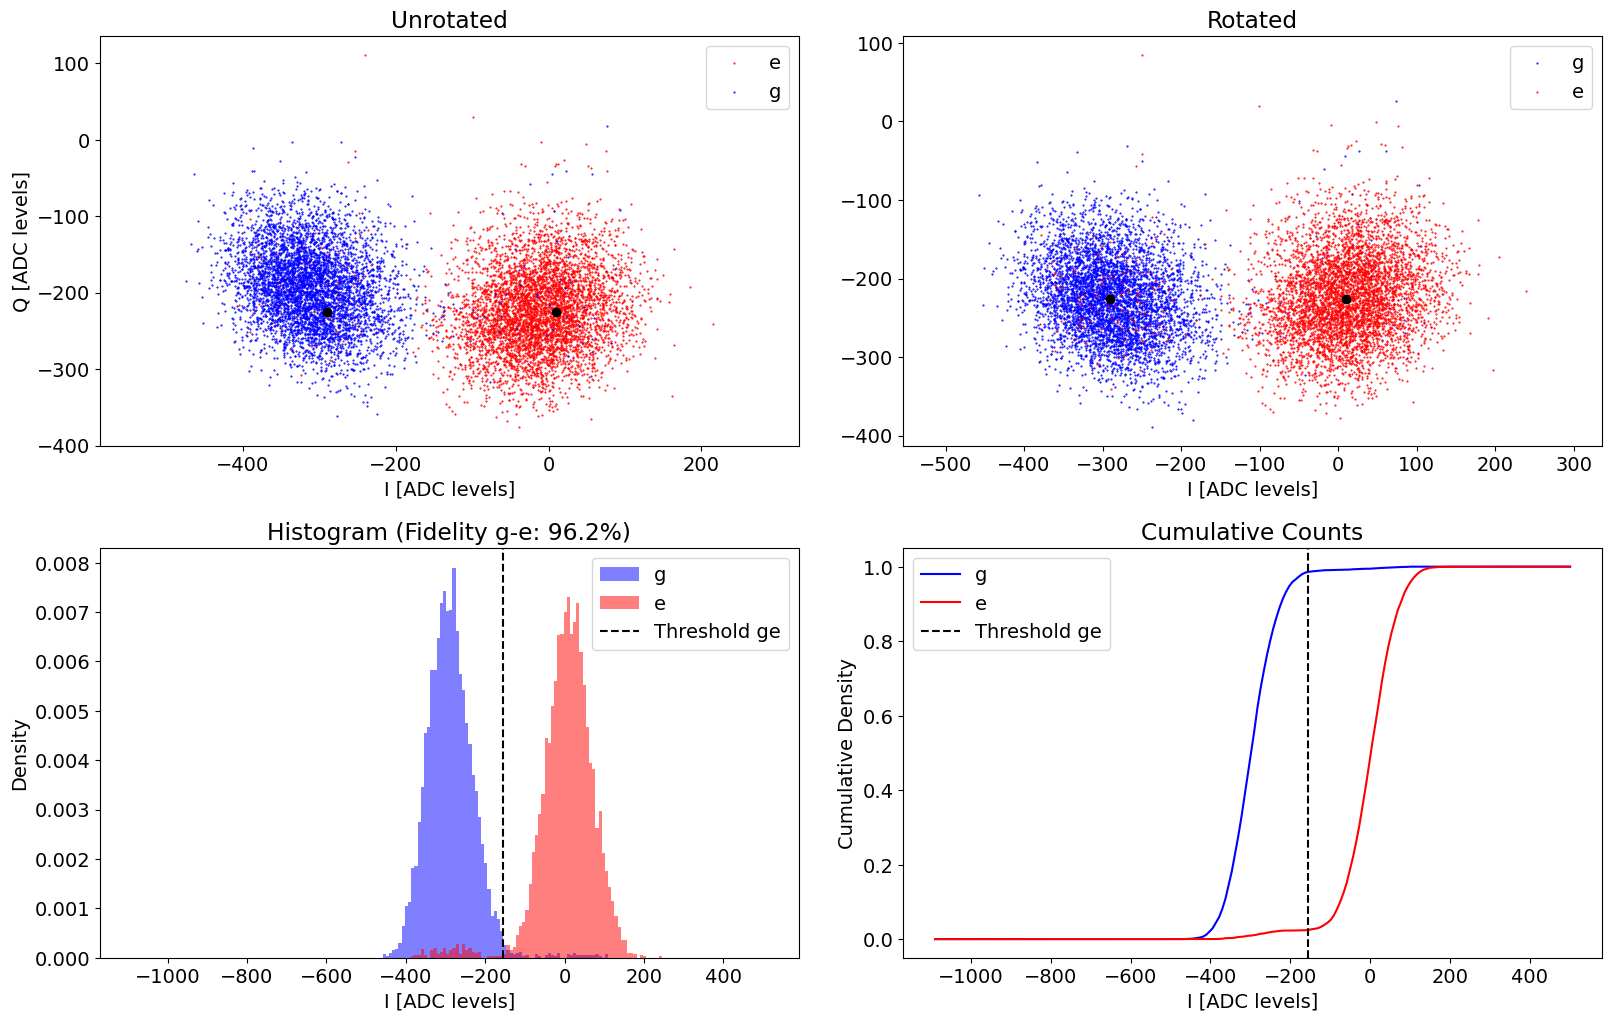

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_20-50-21_histogram.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated readout!
Single shot done!


In [19]:
if expts_to_run['single_shot']:
    update_single_shot(hstgrm, config_thisrun)
    print('Single shot done!')

In [31]:
hstgrm.data

{'Ig': array([ -76.46103896,  -69.50649351,   23.67532468, ..., -107.75649351,
          30.20454545,    8.83116883]),
 'Qg': array([-358.29545455, -461.80194805, -352.8961039 , ..., -445.3961039 ,
        -420.82142857, -258.27597403]),
 'Ie': array([123.56818182,  98.56168831, 201.97727273, ..., 148.05519481,
        177.88961039, 206.03571429]),
 'Qe': array([-276.29220779, -151.29545455,  -68.77597403, ..., -184.84415584,
         -66.31818182, -234.46753247]),
 'Ig_rot': array([-327.82937769, -404.43077015, -261.18775057, ..., -415.44528101,
        -310.23171708, -196.45297313]),
 'Qg_rot': array([-163.55372924, -233.51219245, -238.48928718, ..., -193.37623883,
        -285.9357813 , -167.90085661]),
 'Ie_rot': array([-139.01980712,  -56.86680746,   72.12268203, ...,  -52.24848651,
          59.02958867,  -54.90934494]),
 'Qe_rot': array([-268.84934977, -171.37936626, -200.80655377, ..., -230.99306984,
        -180.43924846, -307.26324737])}

## Qubit ge

### Pulse-probe

In [32]:
def do_pulse_probe_ge(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = dict(
        start=3560,  # [MHz]
        step=0.1,  # min step ~1 MHz
        expts=200,  # Number of experiments stepping from start
        reps=2000,  # Number of averages per point
        rounds=1,  # Number of start to finish sweeps to average over
        length=1,  # Qubit probe constant pulse length [us]
        gain=400,  # Qubit pulse gain
        sigma=0.1,  # Qubit flat top sigma
        pulse_type='gaussian',
        wait_qubit=False,
        qubit=0,
        cavity_drive=False,
        cavity_name=0,  # 0 is man1, 1 is man2
        cavity_gain=4000,
        cavity_length=1,  # Constant pulses of cavity [us]
        cavity_pulse=[False, 0.1]  # Truth value for gaussian cavity pulse, type, sigma
    )


    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ge(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ge = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [33]:
if expts_to_run['pulse_probe_ge']: 
    qspec = do_pulse_probe_ge(config_thisrun)

In [34]:
if expts_to_run['pulse_probe_ge']:
    update_pulse_probe_ge(qspec, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [130]:
def do_t2_ramsey_ge(config_thisrun, expt_path, config_path, 
                    pre_sweep_pulse = None, post_sweep_pulse = None, step_size = 0.2, if_ef = False):
    """Run the T2 Ramsey experiment."""
    t2ramsey = meas.single_qubit.t2_ramsey.RamseyExperiment(
        soccfg=soc, path=expt_path, prefix='RamseyExperiment', config_file=config_path
    )

    t2ramsey.cfg = AttrDict(deepcopy(config_thisrun))
    checkEF = False
    qubit_ge_init = False
    qubit_ge_after = False
    if if_ef:
        checkEF = True
        qubit_ge_init = True
        qubit_ge_after = True


    t2ramsey.cfg.expt = {
        'start': 0.01,
        'step': step_size,
        'expts': 100,
        'ramsey_freq': 0.2,
        'reps': 200,
        'rounds': 1,
        'qubits': [0],
        'checkEF': checkEF,
        'user_defined_freq': [False, 3568.2038290468167, 5304, 0.035],
        'qubit_ge_init': qubit_ge_init,
        'qubit_ge_after': qubit_ge_after,
        'f0g1_cavity': 0,
        'normalize': False,
        'active_reset': False,
        'man_reset': False,
        'storage_reset': False,
        'prepulse': False if pre_sweep_pulse is None else True,
        'postpulse': False if post_sweep_pulse is None else True,
        'pre_active_reset_pulse': False,
        'pre_sweep_pulse': pre_sweep_pulse,
        'post_sweep_pulse': post_sweep_pulse,
        'advance_phase': 0,
        'echoes': [False, 0]
    }

    t2ramsey.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t2ramsey.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import RamseyFitting
    t2ramsey_analysis = RamseyFitting(
        t2ramsey.data, 
        readout_per_round=4, config=t2ramsey.cfg,
    )
    return t2ramsey_analysis


def update_t2_ramsey_ge(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ge = [config_thisrun.device.qubit.f_ge[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ge frequency to:', config_thisrun.device.qubit.f_ge[0])



fge is  3569.459037450159
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00008_RamseyExperiment.h5
Attempted to init fitparam 4 to -130.49438639643182, which is out of bounds -223.8542857142857 to -197.51292207792207. Instead init to -210.68360389610388
Attempted to init fitparam 4 to -210.68360389610388, which is out of bounds 198.40729608017116 to 355.14772077167265. Instead init to 276.7775084259219
Current pi pulse frequency: 3569.459037450159
Fit frequency from I [MHz]: 0.23921981430437197 +/- 0.0003508588570553338
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.4198176358545
 	3569.8982572644636
T2 Ramsey from fit I [us]: 147.06603348220645
Fit frequency from Q [MHz]: 0.16512333586236305 +/- 0.018758767903346758
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.493914114297
 	3569.8241607860214
T2 Ramsey from fit Q [us]: 5.880000000000001


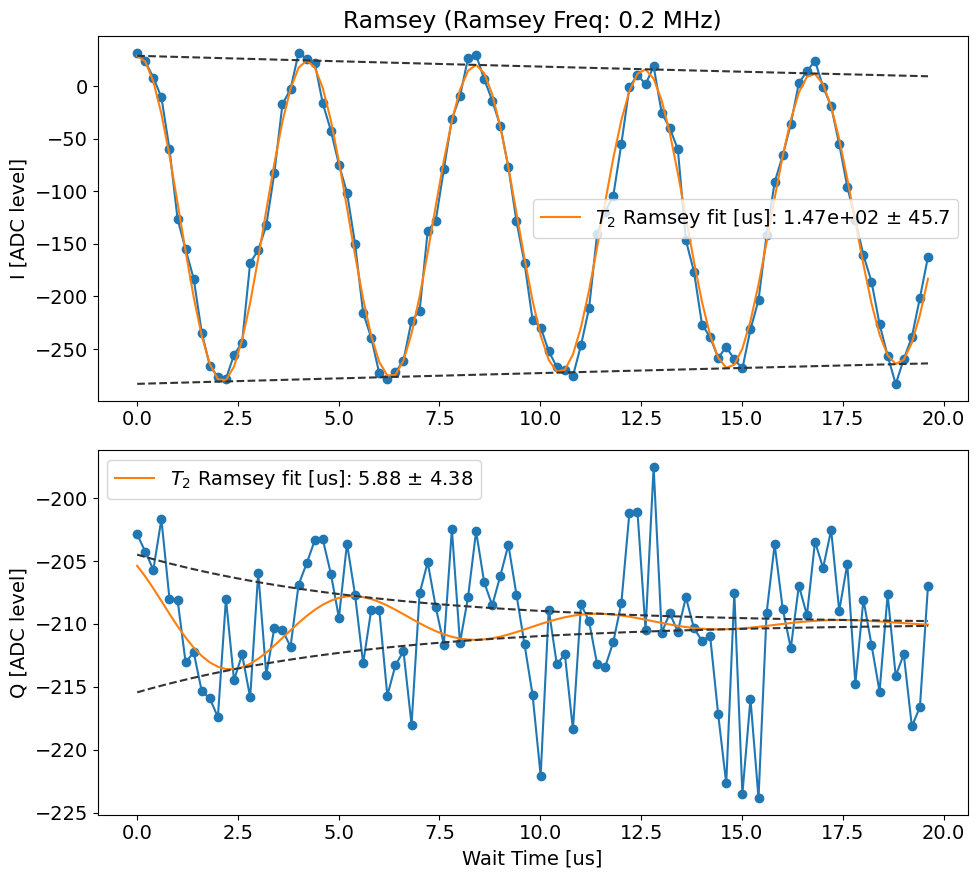

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-03-51_T2_ge.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3569.4198176358545
T2 Ramsey done!


In [123]:
t2ramsey_ge = None
if expts_to_run['t2_ge']:
    t2ramsey_ge = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2ramsey_ge.analyze()
    t2ramsey_ge.display(title_str='T2_ge')
    update_t2_ramsey_ge(t2ramsey_ge, config_thisrun)
    print('T2 Ramsey done!')

In [113]:
config_thisrun.device.qubit.f_ge[0]

3569.419196540533

In [125]:
t2ramsey_ge.data['idata'].shape

(10000,)

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [105]:
def do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef = False):
    """Run the amplitude Rabi experiment."""
    amprabi = meas.single_qubit.amplitude_rabi.AmplitudeRabiExperiment(
        soccfg=soc, path=expt_path, prefix='AmplitudeRabiExperiment', config_file=config_path
    )

    amprabi.cfg = AttrDict(deepcopy(config_thisrun))

    pulse_ge = config_thisrun.device.qubit.pulses.pi_ge

    checkEF = False
    pulse_ge_init = False
    pulse_ge_after = False
    if if_ef:
        checkEF = True
        pulse_ge_init = True
        pulse_ge_init = True

    amprabi.cfg.expt = dict(
        start=50,  # Qubit gain [dac level]
        step=160,  # [dac level]
        expts=151,
        reps=100,
        rounds=1,
        sigma_test=pulse_ge.sigma[0],  # Gaussian sigma for pulse length - overrides config [us]
        qubit=0,
        pulse_type='gauss',  # 'gauss' or 'flat_top' or 'drag' or 'const'
        drag_beta=0.0,
        pulse_ge_init=pulse_ge_init,
        pulse_ge_after=pulse_ge_init,
        checkZZ=False,
        checkEF=checkEF,
        qubits=[0],
        flat_length=0,
        normalize=False,
        single_shot=False,  # For debugging
        singleshot_reps=10000,
        span=50,  # Single shot plot span
        user_defined_freq=[False, 3568.203829046816],  # [on/off, freq]
        prepulse=False,
        postpulse=False
    )

    amprabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    amprabi.go(analyze=False, display=False, progress=True, save=True)

    from multimode_expts.fit_display_classes import AmplitudeRabiFitting
    amprabi_analysis = AmplitudeRabiFitting(
        amprabi.data, 
        readout_per_round=4, config=amprabi.cfg,
    )
    return amprabi_analysis


def update_amplitude_rabi(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ge.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ge.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')



In [70]:
amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)

Readout phase: 2.4274492529170075


  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00000_AmplitudeRabiExperiment.h5


In [ ]:
amprabi = None
t2_ramsey_ge_after_amp = None
if expts_to_run['amplitude_ge']:
    amprabi = do_amplitude_rabi(config_thisrun, expt_path, config_path)
    amprabi.analyze(fitparams=[np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
    amprabi.display(title_str='Amplitude Rabi_ge', save_fig=True)
    update_amplitude_rabi(amprabi, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ge_after_amp  = do_t2_ramsey_ge(config_thisrun, expt_path, config_path)
    t2_ramsey_ge_after_amp.analyze()
    t2_ramsey_ge_after_amp.display(title_str='T2_ge_after_amp')
    update_t2_ramsey_ge(t2_ramsey_ge_after_amp , config_thisrun)
    print('T2 Ramsey done!')

Attempted to init fitparam 4 to -127.55463852813851, which is out of bounds -229.83922077922077 to -196.5414935064935. Instead init to -213.19035714285712
Attempted to init fitparam 4 to -213.19035714285712, which is out of bounds 197.8692579923992 to 359.3909089996301. Instead init to 278.63008349601466
Pi gain from avgi data [dac units]: 11165
	Pi/2 gain from avgi data [dac units]: 5289
Pi gain from avgq data [dac units]: 165470
	Pi/2 gain from avgq data [dac units]: 105870


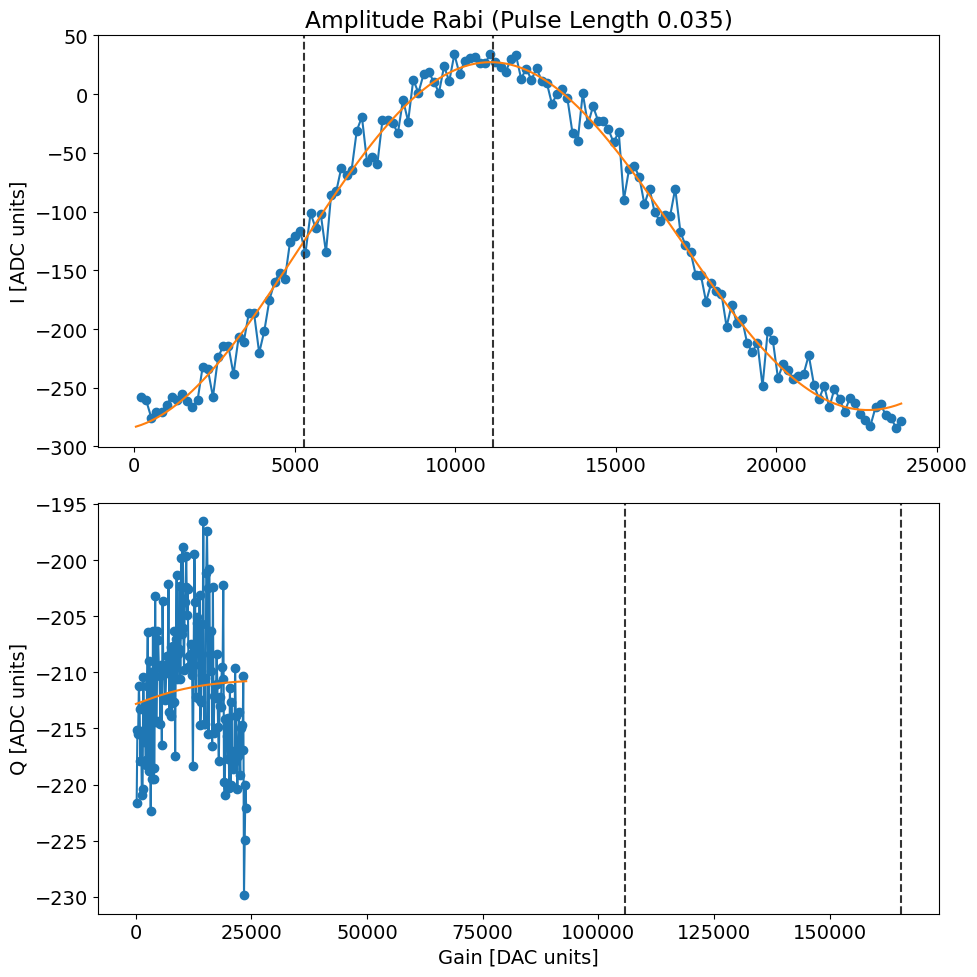

Updated qubit ge pi and hpi gaussian gain!
Amplitude Rabi done!


In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)
# print('Amplitude Rabi done!')

In [ ]:
# amprabi.analyze(fitparams= [np.max(amprabi.data['amps']), 0.0001, 90, None, None, None])
# amprabi.display()
# update_amplitude_rabi(amprabi, config_thisrun)


# Magic Params: [np.max(amprabi.data['amps']), 0.00001, 90, None, None, None]

### T1

In [41]:
def do_t1_ge(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 10,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': False,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ge(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1 = [t1.data['fit_avgi'][3]]
    print('Updated qubit T1!')


In [42]:
t1 = None
if expts_to_run['t1_ge']:
    t1 = do_t1_ge(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ge(t1, config_thisrun)
    print('T1 done!')

## Qubit ef

### Pulse-probe

In [43]:
def do_pulse_probe_ef(config_thisrun): 

    qspec = meas.single_qubit.pulse_probe_spectroscopy.PulseProbeSpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeEFSpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {'start': 3415,
        'step': 0.05,
        'expts': 500,
        'reps': 200,
        'rounds': 1,
        'length': 2,
        'gain': 3000,
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubit': 0}



    qspec.cfg.device.readout.relax_delay = [50] # Wait time between experiments [us]
    qspec.go(analyze=True, display=True, progress=True, save=True)

def update_pulse_probe_ef(qspec, config_thisrun):
    config_thisrun.device.qubit.f_ef = [qspec.data['fit'][0]]
    print('Updated qubit frequency!')

In [44]:
qspec_ef = None
if expts_to_run['pulse_probe_ef']: 
    qspec_ef = do_pulse_probe_ef(config_thisrun)


In [45]:
if expts_to_run['pulse_probe_ef']:
    update_pulse_probe_ef(qspec_ef, config_thisrun)
    print('Pulse probe spectroscopy done!')

### T2 Ramsey

In [ ]:
def do_t2_ramsey_ef(config_thisrun, expt_path, config_path):
    """Run the T2 Ramsey experiment."""
    return do_t2_ramsey_ge(config_thisrun, expt_path, config_path, if_ef=True)


def update_t2_ramsey_ef(t2ramsey, config_thisrun):
    """Update the configuration based on T2 Ramsey experiment results."""
    config_thisrun.device.qubit.f_ef = [config_thisrun.device.qubit.f_ef[0] + min(t2ramsey.data['f_adjust_ramsey_avgi'])]
    print('Updated qubit ef frequency to:', config_thisrun.device.qubit.f_ef[0])



fge is  3569.4198176358545
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00009_RamseyExperiment.h5
Attempted to init fitparam 4 to -107.42805555555555, which is out of bounds 56.05381257247189 to 345.5046828865387. Instead init to 200.7792477295053
Current pi pulse frequency: 3426.2579958470365
Fit frequency from I [MHz]: 0.16169171910657001 +/- 0.000693450320694546
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.29630412793
 	3426.619687566143
T2 Ramsey from fit I [us]: 55.45725327787514
Fit frequency from Q [MHz]: 0.16215684754314066 +/- 0.000757229894309573
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2958389994933
 	3426.6201526945797
T2 Ramsey from fit Q [us]: 59.46249983200593


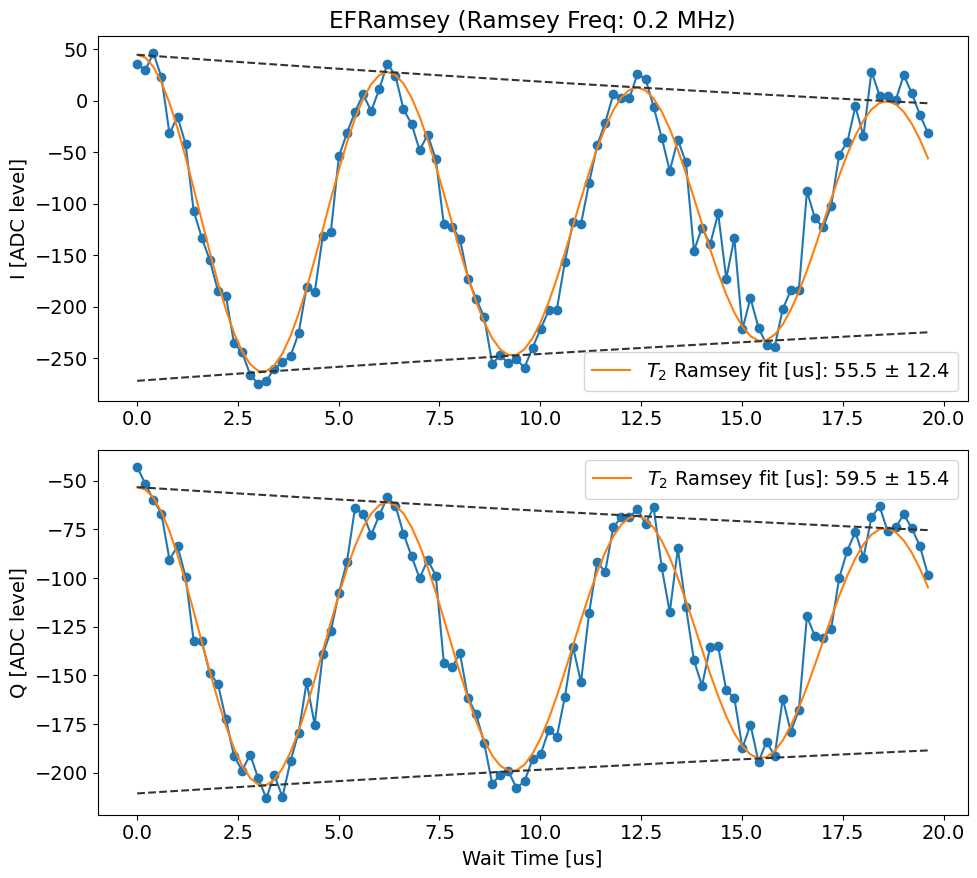

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-05-33_T2_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.29630412793
T2 Ramsey done!


In [124]:
t2ramsey_ef = None
if expts_to_run['t2_ef']:
    t2ramsey_ef = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2ramsey_ef.analyze()
    t2ramsey_ef.display(title_str='T2_ef')
    update_t2_ramsey_ef(t2ramsey_ef, config_thisrun)
    print('T2 Ramsey done!')

In [48]:
# t2ramsey_ge.analyze()
# t2ramsey_ge.display()
    

### Amplitude Rabi

We should probably use a cosine fit with fixed phase=0 instead of decaying sine with varying phase?

In [117]:
def do_amplitude_rabi_ef(config_thisrun, expt_path, config_path):
    """Run the amplitude Rabi experiment."""
    return do_amplitude_rabi(config_thisrun, expt_path, config_path, if_ef=True)


def update_amplitude_rabi_ef(amprabi, config_thisrun):
    """Update the configuration based on amplitude Rabi experiment results."""
    config_thisrun.device.qubit.pulses.pi_ef.gain = [amprabi.data['pi_gain_avgi']]
    config_thisrun.device.qubit.pulses.hpi_ef.gain = [amprabi.data['hpi_gain_avgi']]
    print('Updated qubit ef pi and hpi gaussian gain!')



Readout phase: 2.4274492529170075


  0%|          | 0/15100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00003_AmplitudeRabiExperiment.h5
Pi gain from avgi data [dac units]: 8627
	Pi/2 gain from avgi data [dac units]: 4136
Pi gain from avgq data [dac units]: 8038
	Pi/2 gain from avgq data [dac units]: 4514


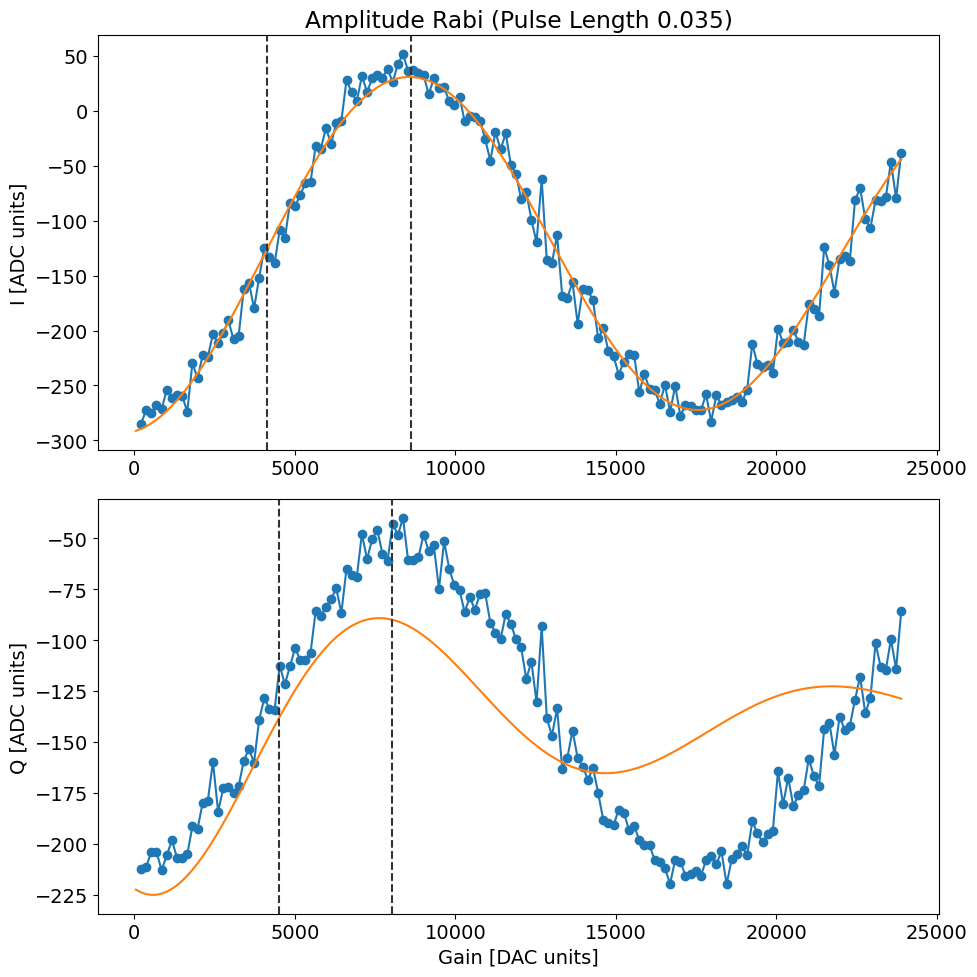

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-15-01_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ef pi and hpi gaussian gain!
Amplitude Rabi done!
fge is  3569.4198176358545
fef is  3426.3164023718723


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00012_RamseyExperiment.h5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Attempted to init fitparam 4 to -116.55440345008529, which is out of bounds 60.73323445408372 to 348.7263250437679. Instead init to 204.7297797489258
Fit Failed ; aborting
Current pi pulse frequency: 3426.3164023718723
Fit frequency from I [MHz]: 0.2 +/- inf
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.3164023718723
 	3426.7164023718724
T2 Ramsey from fit I [us]: 200
Fit frequency from Q [MHz]: 0.21865964386535208 +/- 0.0005917047369645204
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.297742728007
 	3426.7350620157376
T2 Ramsey from fit Q [us]: 42.23626129066185


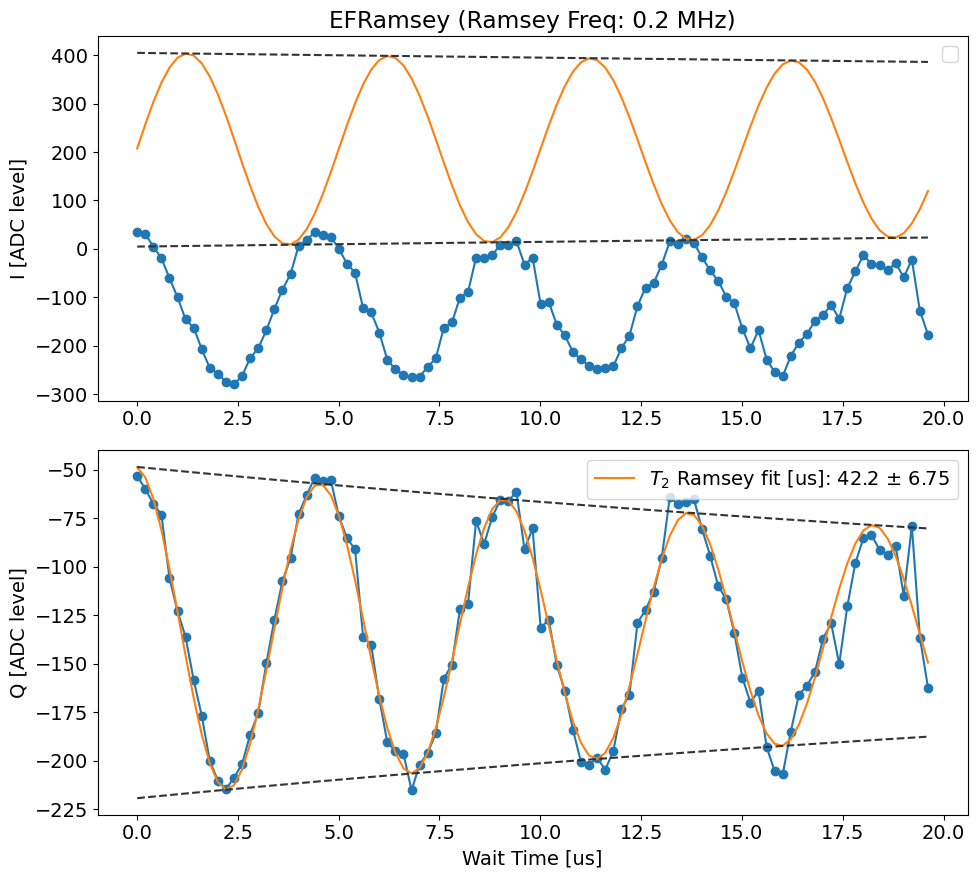

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-15-57_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.3164023718723
T2 Ramsey done!


In [132]:
amprabi_ef = None
t2_ramsey_ef_after_amp = None
if expts_to_run['amplitude_ef']:
    amprabi_ef = do_amplitude_rabi_ef(config_thisrun, expt_path, config_path)
    amprabi_ef.analyze()
    amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)
    update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
    print('Amplitude Rabi done!')

    # After this do another round of T2 to fine tune the qubit frequency
    t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
    t2_ramsey_ef_after_amp.analyze()
    t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
    update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
    print('T2 Ramsey done!')

Pi gain from avgi data [dac units]: 8540
	Pi/2 gain from avgi data [dac units]: 4002
Pi gain from avgq data [dac units]: 8521
	Pi/2 gain from avgq data [dac units]: 3985


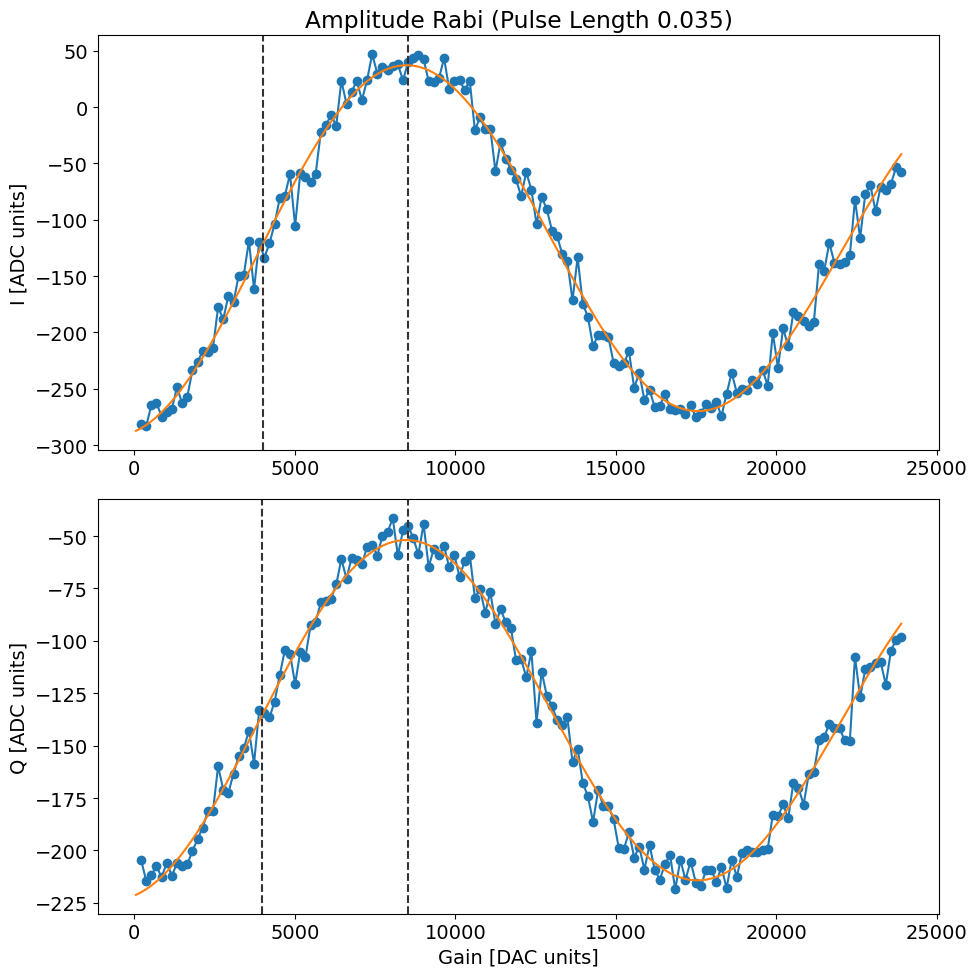

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-07-35_Amplitude_Rabi_ef.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md


In [ ]:
# amprabi_ef.display(title_str = 'Amplitude Rabi_ef', save_fig=True)

fge is  3569.4198176358545
fef is  3426.3181805352324


  0%|          | 0/20000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00011_RamseyExperiment.h5
Attempted to init fitparam 4 to -117.69186770300406, which is out of bounds 57.8644317424725 to 346.2564709215713. Instead init to 202.0604513320219
Current pi pulse frequency: 3426.3181805352324
Fit frequency from I [MHz]: 0.20177816336002957 +/- 0.00046997561004176805
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.3164023718723
 	3426.7199586985926
T2 Ramsey from fit I [us]: 50.31470850686472
Fit frequency from Q [MHz]: 0.20238194366665718 +/- 0.0005600947913224493
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.315798591566
 	3426.720562478899
T2 Ramsey from fit Q [us]: 60.757146958568825


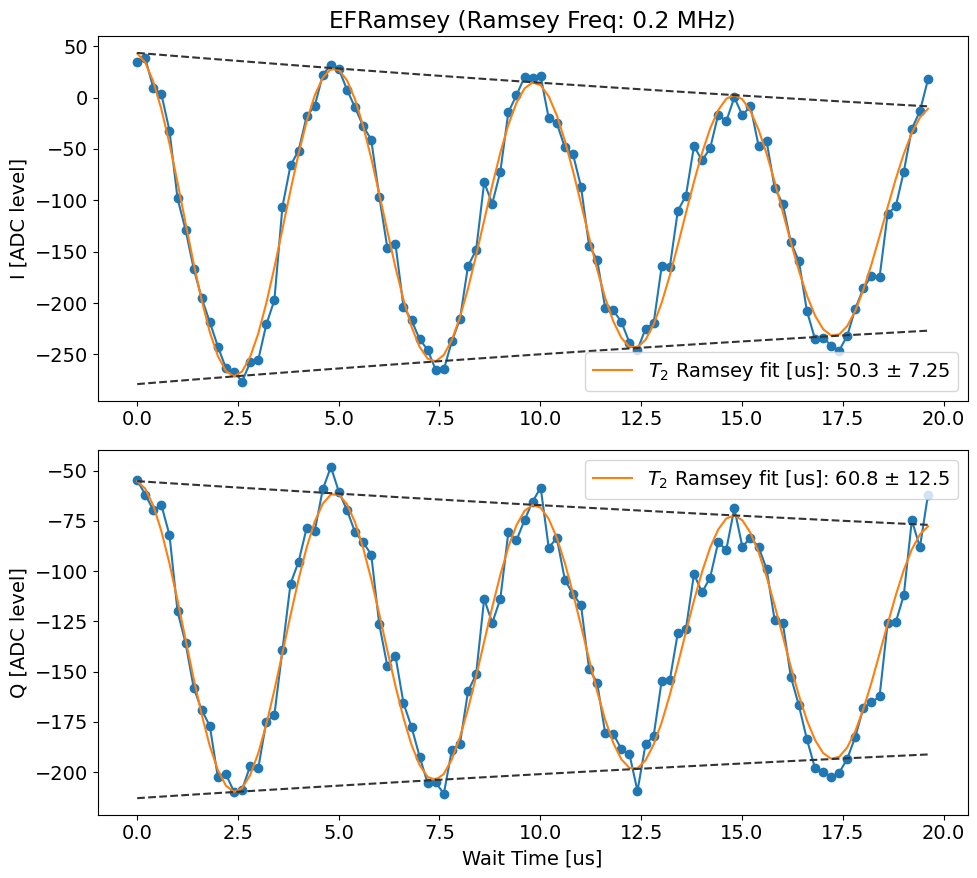

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-13-45_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.3164023718723
T2 Ramsey done!


In [ ]:
# update_amplitude_rabi_ef(amprabi_ef, config_thisrun)
# print('Amplitude Rabi done!')

# After this do another round of T2 to fine tune the qubit frequency
# t2_ramsey_ef_after_amp  = do_t2_ramsey_ef(config_thisrun, expt_path, config_path)
# t2_ramsey_ef_after_amp.analyze()
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)
# print('T2 Ramsey done!')

Attempted to init fitparam 4 to -116.55440345008529, which is out of bounds 60.73323445408372 to 348.7263250437679. Instead init to 204.7297797489258
Current pi pulse frequency: 3426.3164023718723
Fit frequency from I [MHz]: 0.21882570632979814 +/- 0.0005380744558043492
Suggested new pi pulse frequency from fit I [MHz]:
 	3426.2975766655427
 	3426.735228078202
T2 Ramsey from fit I [us]: 44.81982491598512
Fit frequency from Q [MHz]: 0.21862336100212773 +/- 0.0005909327735314028
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3426.2977790108703
 	3426.7350257328744
T2 Ramsey from fit Q [us]: 36.84019802269955


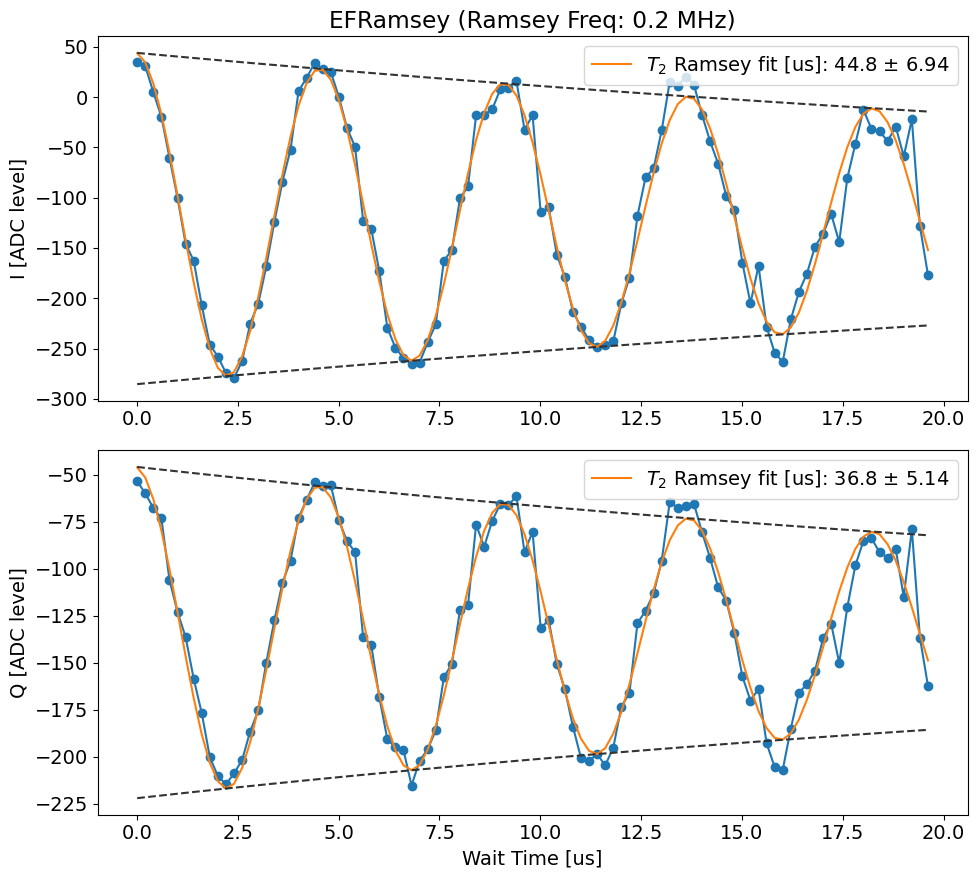

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_11-17-28_T2_ef_after_amp.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated qubit ge frequency to: 3426.2975766655427


In [ ]:
# t2_ramsey_ef_after_amp.analyze(fitparams=[300, None, None, None, None, None])
# t2_ramsey_ef_after_amp.display(title_str='T2_ef_after_amp')
# update_t2_ramsey_ef(t2_ramsey_ef_after_amp , config_thisrun)

### T1

In [51]:
def do_t1_ef(config_thisrun, expt_path, config_path):
    """Run the T1 experiment."""
    t1 = meas.single_qubit.t1.T1Experiment(
        soccfg=soc, path=expt_path, prefix='T1Experiment', config_file=config_path
    )

    t1.cfg = AttrDict(deepcopy(config_thisrun))

    t1.cfg.expt = {
        'start': 0,
        'step': 5,
        'expts': 100,
        'reps': 50,
        'rounds': 1,
        'qubit': 0,
        'qubit_ef': True,
        'normalize': False
    }

    t1.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    t1.go(analyze=True, display=True, progress=True, save=True)
    return t1


def update_t1_ef(t1, config_thisrun):
    """Update the configuration based on T1 experiment results."""
    config_thisrun.device.qubit.T1_ef = [t1.data['fit_avgq'][3]]
    print('Updated qubit T1!')


In [52]:
t1_ef = None
if expts_to_run['t1_ef']:
    t1 = do_t1_ef(config_thisrun, expt_path, config_path)
    t1.analyze()
    t1.display()
    update_t1_ef(t1, config_thisrun)
    print('T1 done!')

# Manipulate

## Spectroscopy

In [141]:
def do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = 1): 

    qspec = meas.single_qubit.pulse_probe_f0g1_spectroscopy.PulseProbeF0g1SpectroscopyExperiment(
        soccfg=soc, path=expt_path, prefix='PulseProbeF0g1SpectroscopyExperiment', config_file=config_path
    )

    qspec.cfg = AttrDict(deepcopy(config_thisrun))

    qspec.cfg.expt = {
        'start': ds_thisrun.get_freq('M' + str(man_mode_no)) - 2,  # resonator frequency to be mixed up [MHz]
        'step': 0.02,  # min step ~1 MHz
        'expts': 300,  # Number of experiments stepping from start
        'reps': 100,  # Number of averages per point
        'rounds': 1,  # Number of start to finish sweeps to average over
        'length': 1,  # ef probe constant pulse length [us]
        'gain': 5000,  # f0g1 pulse gain
        'pulse_type': 'gaussian',
        'qubit_f': True,
        'qubits': [0],
        'prepulse': False,
        'pre_sweep_pulse': [[3569.4827896982997], [11161], [0], [0], [2], ['g'], [0.035]]
    }

    qspec.cfg.device.readout.relax_delay = [200] # Wait time between experiments [us]
    qspec.go(analyze=False, display=False, progress=True, save=True)
    return qspec

def analyze_and_display_pulse_probe_f0g1(qspec):
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(
        qspec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()

def update_pulse_probe_f0g1(qspec, config_thisrun, man_mode_no = 1):
    ''' 
    Update the configuration based on f0g1 spectroscopy experiment results.
    man_mode_no: 1 for man1, 2 for man2
    '''
    ds_thisrun.update_freq('M' + str(man_mode_no),  qspec.data['fit_avgi'][2])
    print('Updated man f0g1 freq to :', config_thisrun.device.manipulate.f0g1_freq[man_mode_no - 1])


Running pulse probe f0g1 for mode 1


  0%|          | 0/30000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00020_PulseProbeF0g1SpectroscopyExperiment.h5
Found peak in amps at [MHz] 2009.7472506054385, HWHM 0.4379890210255317
Found peak in I at [MHz] 2009.7444473320718, HWHM 0.4389563394135119
Found peak in Q at [MHz] 2009.7538489820745, HWHM 0.4497967415812675


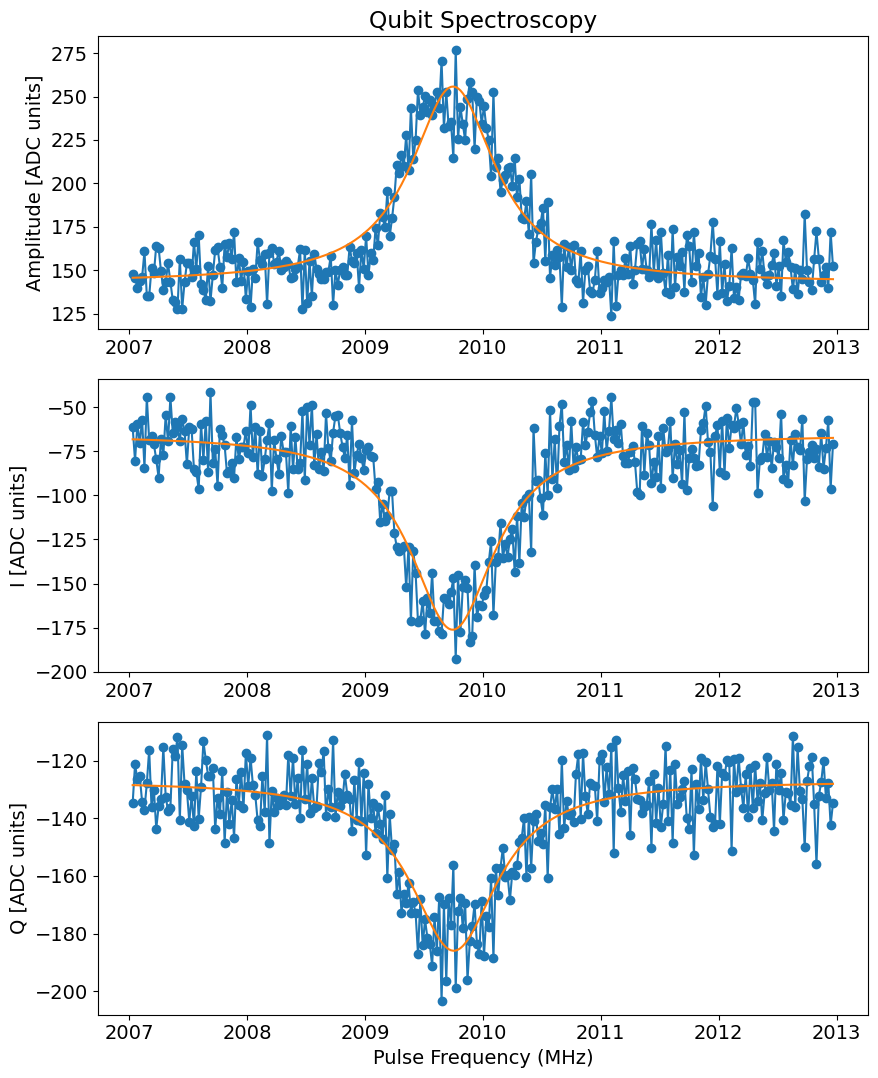

Updated man f0g1 freq to : 2007.09


In [46]:
man_specs =[None]* len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):

    if expts_to_run['pulse_probe_f0g1']:

        print('Running pulse probe f0g1 for mode', i+1)
        man_specs[i] = do_pulse_probe_f0g1(config_thisrun, ds_thisrun, man_mode_no = i+1)
        analyze_and_display_pulse_probe_f0g1(man_specs[i])
        update_pulse_probe_f0g1(man_specs[i], config_thisrun, man_mode_no=i+1)
        

## Find Frequency (Chevron)


In [47]:
%matplotlib inline

In [142]:
def do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step):
    """Run the Length Rabi General F0g1 Experiment Sweep."""
    # length_rabi = meas.single_qubit.length_rabi.LengthRabiGeneralF0g1ExperimentSweep(
    #     soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1ExperimentSweep', config_file=config_path
    # )
    from multimode_expts.sequential_experiment_classes import man_f0g1_class
    experiment_class = man_f0g1_class
    sweep_experiment_name = 'length_rabi_f0g1_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    class_for_exp.loaded[sweep_experiment_name] = {
        'freq_start': freq_start,
        'freq_stop':  freq_stop,
        'freq_step': freq_step,
        'start': 30,
        'step': 0.05,
        'qubits': [0],
        'expts': 101,
        'reps': 100,
        'rounds': 1,
        'gain': 15000,
        'ramp_sigma': 0.005,
        'use_arb_waveform': False,
        'pi_ge_before': True,
        'pi_ef_before': True,
        'pi_ge_after': False,
        'normalize': False,
        'active_reset': False,
        'check_man_reset': [False, 0],
        'check_man_reset_pi': [],
        'prepulse': False,
        'pre_sweep_pulse': []
    }
 
    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)

def update_length_rabi_f0g1_sweep(expt_path, prefix, config_thisrun, man_mode_no = 1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix=prefix)
    print('File saved at :', filename)
    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}_{current_time}')

    #config_thisrun.device.manipulate.f0g1_freq[0] = chevron_analysis.results['frequency']
    ds_thisrun.update_freq('M' + str(man_mode_no), chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis



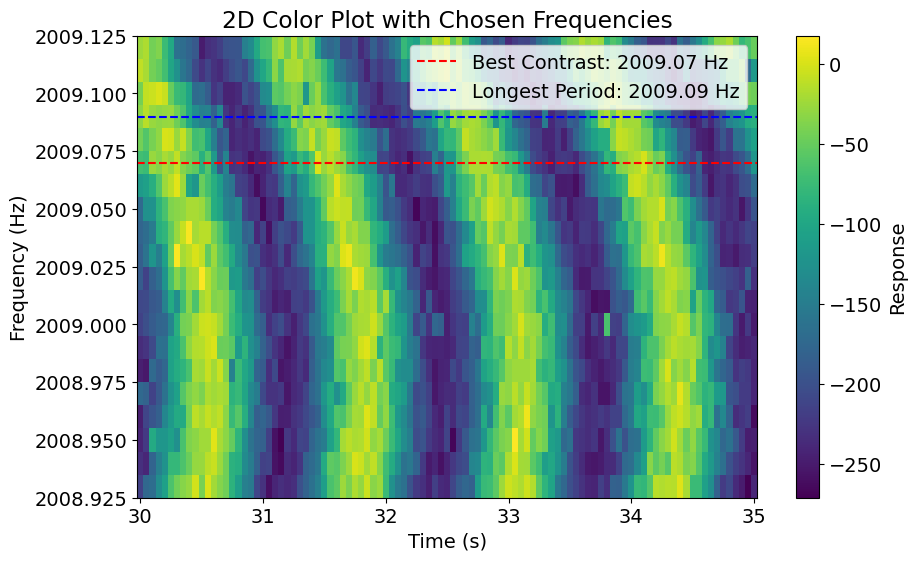

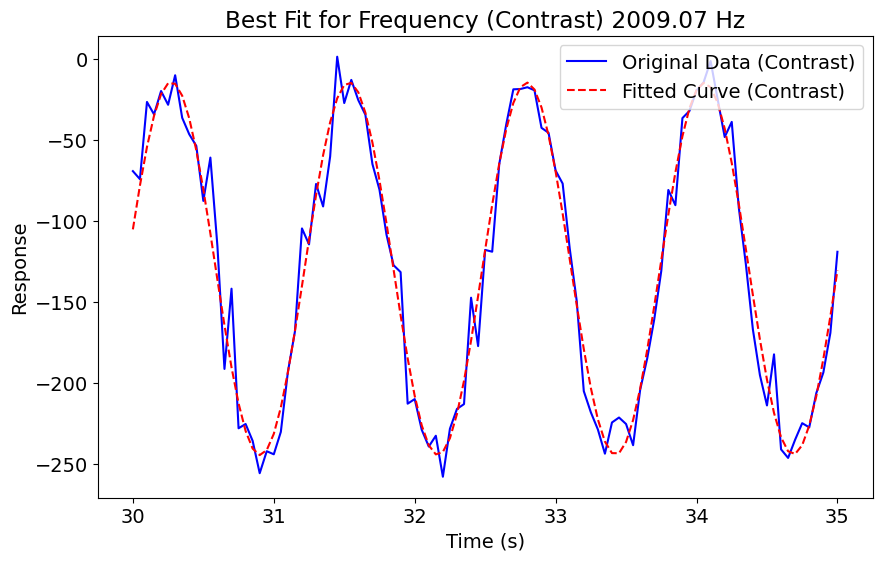

File saved at : H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00000_length_rabi_f0g1_sweep.h5
Figure saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\autocalibration_plots_2025-05-22\M1_2025-05-22_11-32-06


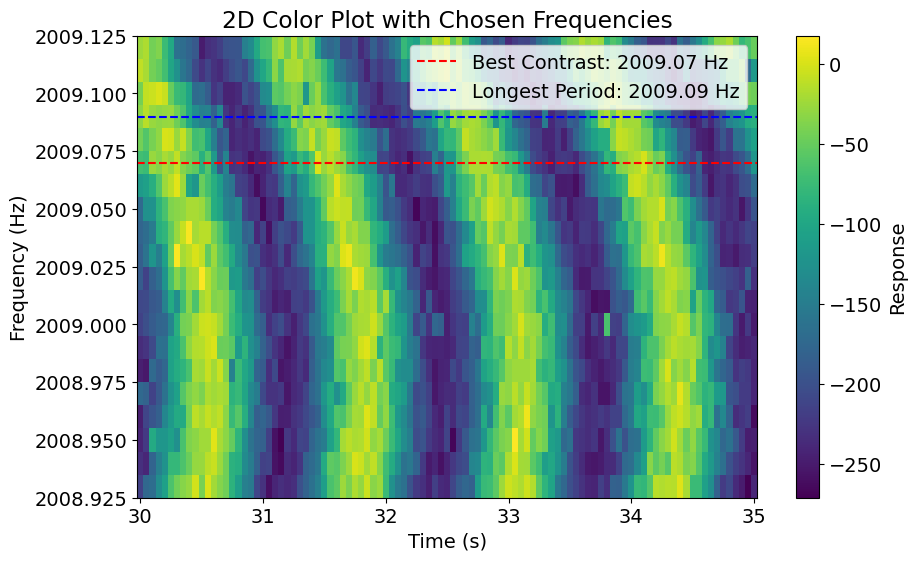

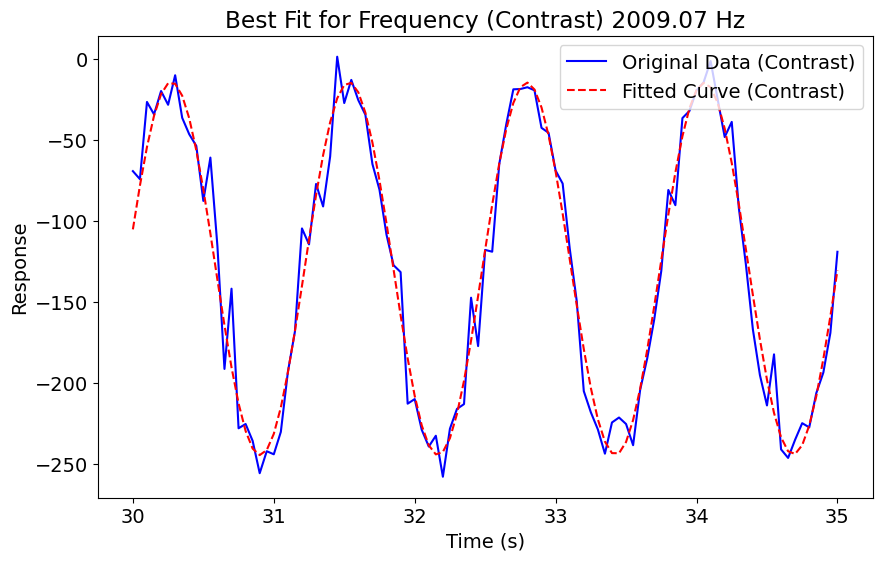

Updated the frequency to: 2009.07


In [ ]:
man_chevrons_coarse = [None] * len(expts_to_run['man_modes'])
man_chevrons_fine = [None] * len(expts_to_run['man_modes'])
# man_sweeps = [None] * len(expts_to_run['man_modes'])

for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi_sweep']:
        print(f'Running coarse length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 2
        freq_step = 0.2
        man_chevrons_coarse[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

        print(f'Running fine length rabi sweep for mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M' + str(i + 1)) + 0.2
        freq_step = 0.01
        man_chevrons_fine[i] = do_length_rabi_f0g1_sweep(config_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step)
        update_length_rabi_f0g1_sweep(expt_path, 'length_rabi_f0g1_sweep', config_thisrun, man_mode_no=i + 1)

In [148]:
ds_thisrun.update_freq('M1',  2008.975)

## Length Rabi f0g1 (Update time)

In [ ]:
def do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 Experiment."""
    length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
    )

    length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

    length_rabi.cfg.expt = dict(
        start=0.0069754464285714285,  # Pulse start length [us]
        step=0.04,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=200,
        rounds=1,
        gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[
        ],
        prepulse=False,
        pre_sweep_pulse=[
        ]
    )

    length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
    length_rabi.go(analyze=False, display=False, progress=True, save=True)
    return length_rabi


def update_length_rabi_f0g1_combined(length_rabi, config_thisrun, ds, man_mode_no = 1):
    """Update the configuration and dataset based on Length Rabi General F0g1 experiment results."""
    from multimode_expts.fit_display_classes import LengthRabiFitting
    # Analyze the data
    length_rabi_analysis = LengthRabiFitting(length_rabi.data, config = config_thisrun)
    length_rabi_analysis.analyze()
    length_rabi_analysis.display(title_str='Length Rabi General F0g1')

    # Update dataset
    pi_length = length_rabi_analysis.results['pi_length']
    pi2_length = length_rabi_analysis.results['pi2_length']
    gain = length_rabi.cfg.expt['gain']
    freq = length_rabi.cfg.expt['freq']
    ds.update_all('M' + str(man_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running length rabi for mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00002_LengthRabiGeneralF0g1Experiment.h5
Pi length: 0.6336344988370962
Pi/2 length: 0.313482947403078
Pi length: 0.6306209158427425
Pi/2 length: 0.30718246504928653


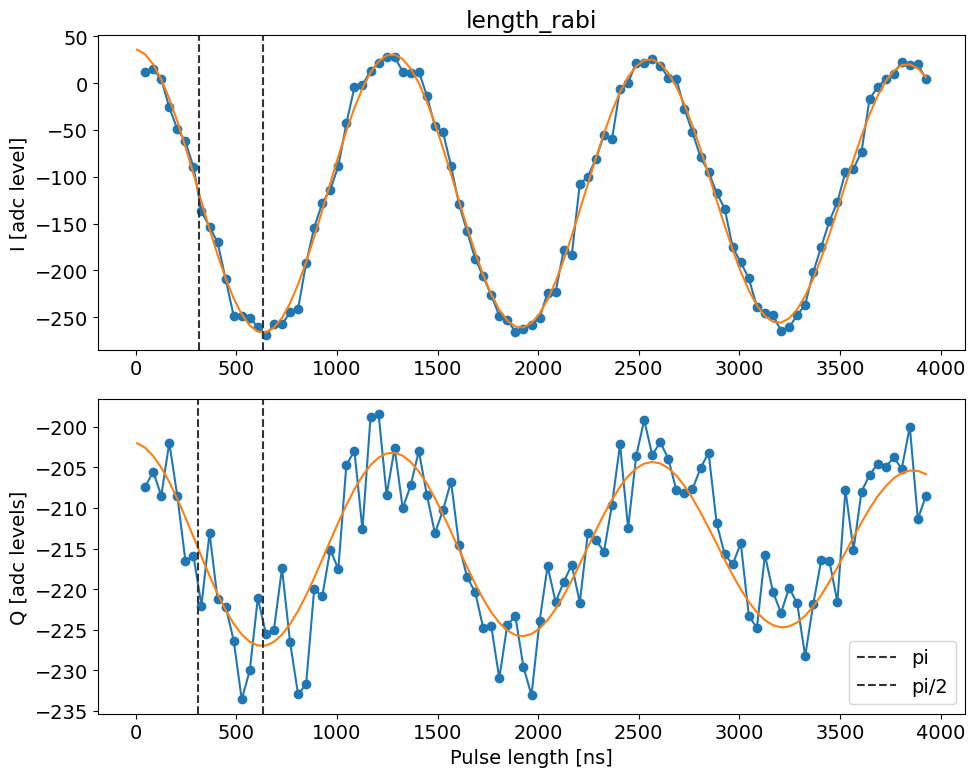

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_20-52-41_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated dataset: pi_length=0.6336344988370962, pi2_length=0.313482947403078, gain=15000


In [21]:
len_rabis_mans = [None]* len(expts_to_run['man_modes'])
for i in range(len(expts_to_run['man_modes'])):
    if expts_to_run['length_rabi'] or expts_to_run['length_rabi_sweep']:
        print('Running length rabi for mode', i+1)
        len_rabis_mans[i] = do_length_rabi_f0g1_general(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no= i+1)
        update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)
        

Pi length: 0.6336344988370962
Pi/2 length: 0.313482947403078
Pi length: 0.6306209158427425
Pi/2 length: 0.30718246504928653


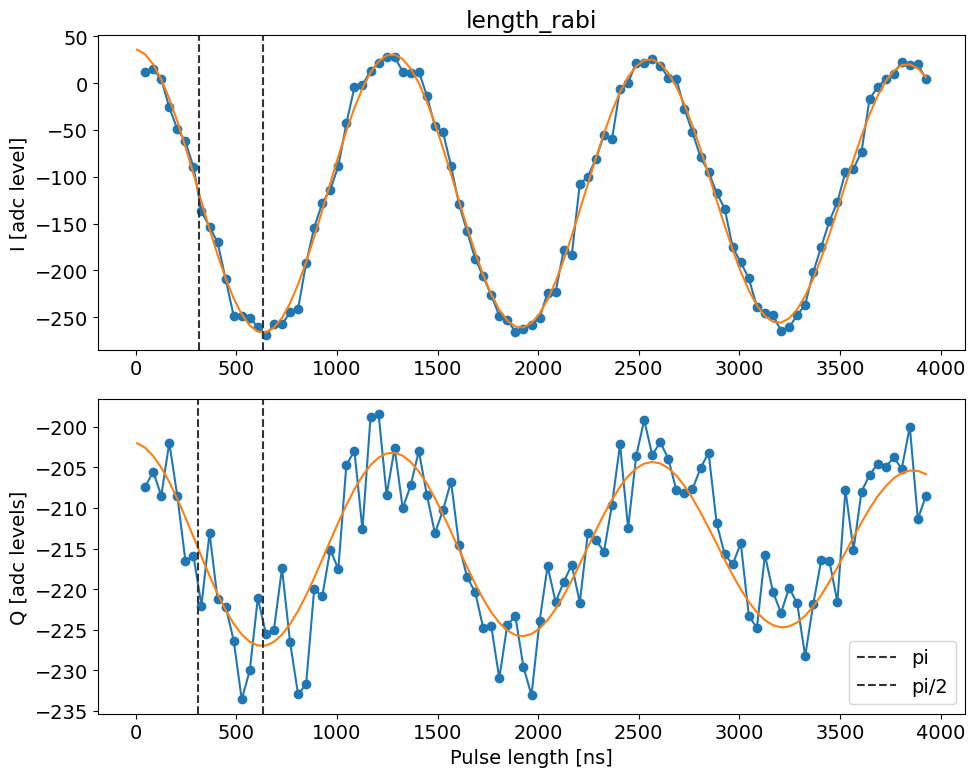

supertitle is  None
Plot saved to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs/plots\2025-05-22_20-52-42_Length_Rabi_General_F0g1.png
Plot path appended to H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\plots_and_logs\2025-05-22.md
Updated dataset: pi_length=0.6336344988370962, pi2_length=0.313482947403078, gain=15000


In [22]:
i = 0
update_length_rabi_f0g1_combined(len_rabis_mans[i], config_thisrun, ds_thisrun, man_mode_no= i+1)

### Quick and dirty error amplification

Very slightly modified length rabi f0g1 general (see git)

In [54]:
soc.cycles2us(1)

0.0023251488095238095

In [55]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_pi('M1')-soc.cycles2us(1)*30,  # Pulse start length [us]
        step=soc.cycles2us(1),  # Pulse step length [us]
        qubits=[0],
        expts=60,
        reps=200,
        rounds=1,
        rep_start=0, # 0 means just 1 pi pulse, no error amp
        rep_end=9, # will do 1+2*rep_end rounds of pi pulses max
        gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [56]:
length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)

 10%|█         | 1/10 [00:35<05:22, 35.78s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00028_LengthRabiGeneralF0g1Experiment.h5


 20%|██        | 2/10 [01:11<04:46, 35.87s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00029_LengthRabiGeneralF0g1Experiment.h5


 30%|███       | 3/10 [01:47<04:10, 35.85s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00030_LengthRabiGeneralF0g1Experiment.h5


 40%|████      | 4/10 [02:23<03:35, 35.91s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00031_LengthRabiGeneralF0g1Experiment.h5


 50%|█████     | 5/10 [02:59<02:59, 35.90s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00032_LengthRabiGeneralF0g1Experiment.h5


 60%|██████    | 6/10 [03:35<02:23, 35.92s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00033_LengthRabiGeneralF0g1Experiment.h5


 70%|███████   | 7/10 [04:11<01:47, 35.99s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00034_LengthRabiGeneralF0g1Experiment.h5


 80%|████████  | 8/10 [04:47<01:12, 36.09s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00035_LengthRabiGeneralF0g1Experiment.h5


 90%|█████████ | 9/10 [05:24<00:36, 36.16s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00036_LengthRabiGeneralF0g1Experiment.h5


100%|██████████| 10/10 [06:00<00:00, 36.05s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00037_LengthRabiGeneralF0g1Experiment.h5


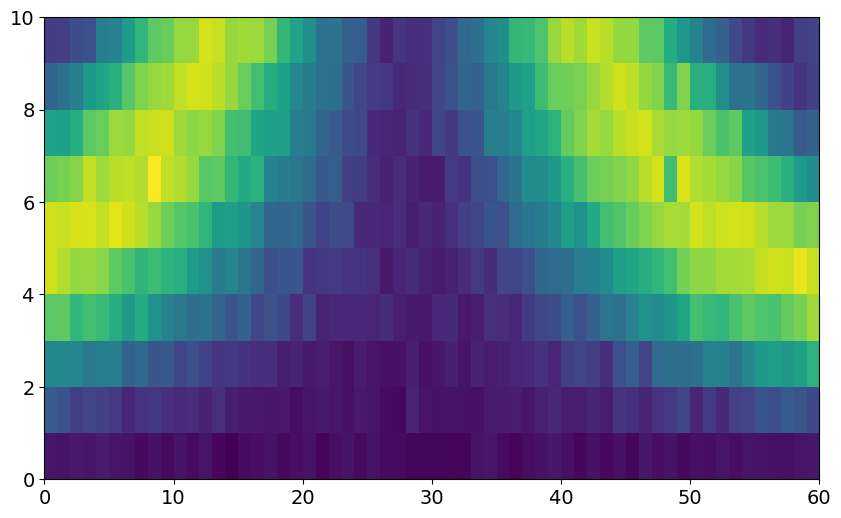

In [57]:
lines = []
for prefix_num in range(28,38):
    fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
    temp_data, attrs, filename = prev_data(expt_path, fname)
    lines.append(temp_data['avgi'])

lines = np.array(lines)
plt.pcolormesh(lines)

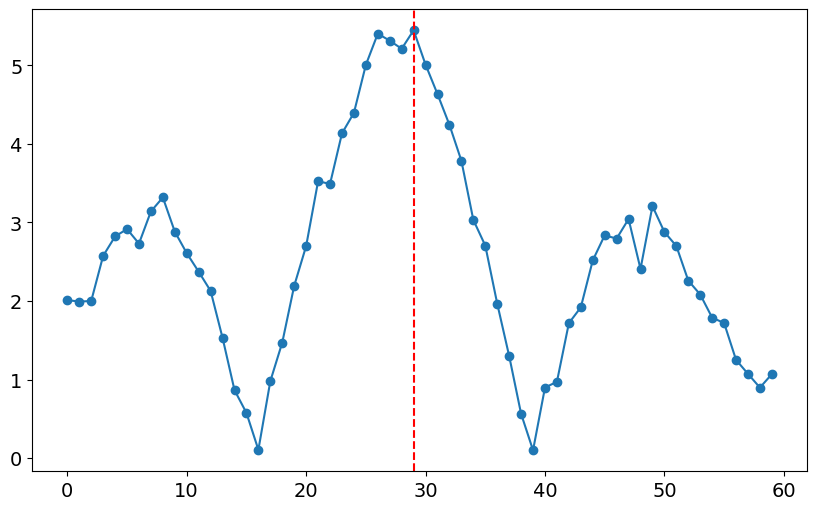

In [ ]:
lines_processed = np.abs(np.prod((lines-lines.mean())/(np.max(lines)-lines.mean()), axis=0))
xmax = np.argmax(lines_processed)
                          
plt.plot(lines_processed, marker='o')
plt.axvline(x=xmax, color='r', linestyle='--')


### and amplitude

In [ ]:
def length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no = 1):
    """Run the Length Rabi General F0g1 repeatedly to amplify error."""

    expt_cfg = dict(
        start=ds_thisrun.get_gain(f'M{man_mode_no}')-20,  # Pulse start length [dac unit]
        step=1,  # Pulse step length [dac unit]
        qubits=[0],
        expts=40,
        reps=200,
        rounds=1,
        rep_start=1,
        rep_end=5,
        # gain=15000,  # Qubit gain [DAC units]
        ramp_sigma=0.005,  # Ramp sigma [us]
        freq= ds_thisrun.get_freq('M' + str(man_mode_no)),  # Frequency [MHz]
        length= ds_thisrun.get_pi(f'M{man_mode_no}'),
        use_arb_waveform=False,
        pi_ge_before=True,
        pi_ef_before=True,
        pi_ef_after=True,
        normalize=False,
        active_reset=False,
        check_man_reset=[False, 0],
        swap_lossy=False,
        check_man_reset_pi=[],
        prepulse=False,
        pre_sweep_pulse=[]
    )

    for err_amp_reps in tqdm(range(expt_cfg['rep_start'], expt_cfg['rep_end'] + 1)):
        length_rabi = meas.single_qubit.length_rabi_f0g1_general.LengthRabiGeneralF0g1Experiment(
            soccfg=soc, path=expt_path, prefix='LengthRabiGeneralF0g1Experiment', config_file=config_path
        )

        length_rabi.cfg = AttrDict(deepcopy(config_thisrun))

        expt_cfg['err_amp_reps'] = err_amp_reps

        length_rabi.cfg.expt = expt_cfg

        length_rabi.cfg.device.readout.relax_delay = [2500]  # Wait time between experiments [us]
        length_rabi.go(analyze=False, display=False, progress=False, save=True)
    return length_rabi

In [ ]:
length_rabi_f0g1_err_amp(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1)
    

 10%|█         | 1/10 [00:35<05:22, 35.83s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00008_LengthRabiGeneralF0g1Experiment.h5


 20%|██        | 2/10 [01:11<04:46, 35.83s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00009_LengthRabiGeneralF0g1Experiment.h5


 30%|███       | 3/10 [01:47<04:11, 35.87s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00010_LengthRabiGeneralF0g1Experiment.h5


 40%|████      | 4/10 [02:23<03:35, 35.95s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00011_LengthRabiGeneralF0g1Experiment.h5


 50%|█████     | 5/10 [02:59<03:00, 36.03s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00012_LengthRabiGeneralF0g1Experiment.h5


 60%|██████    | 6/10 [03:35<02:24, 36.01s/it]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00013_LengthRabiGeneralF0g1Experiment.h5


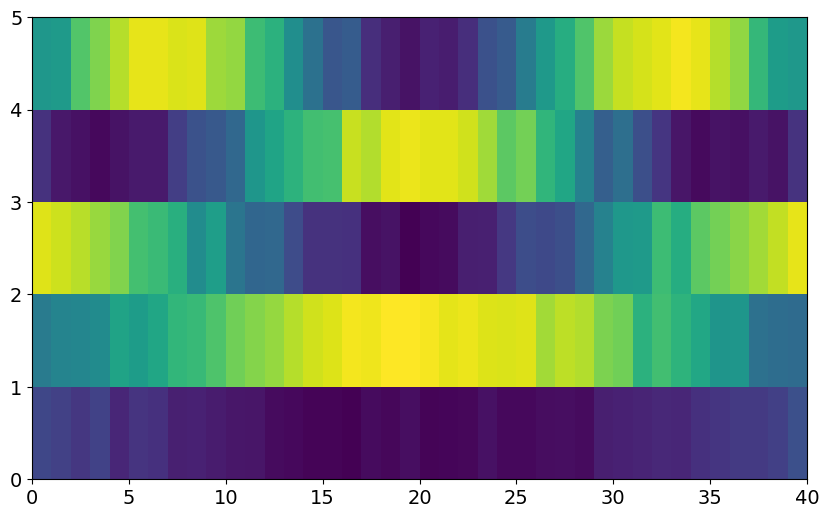

In [ ]:
lines = []
for prefix_num in range(3,8):
    fname = f'{prefix_num:05d}_LengthRabiGeneralF0g1Experiment.h5'
    temp_data, attrs, filename = prev_data(expt_path, fname)
    lines.append(temp_data['avgi'])

lines = np.array(lines)
plt.pcolormesh(lines)

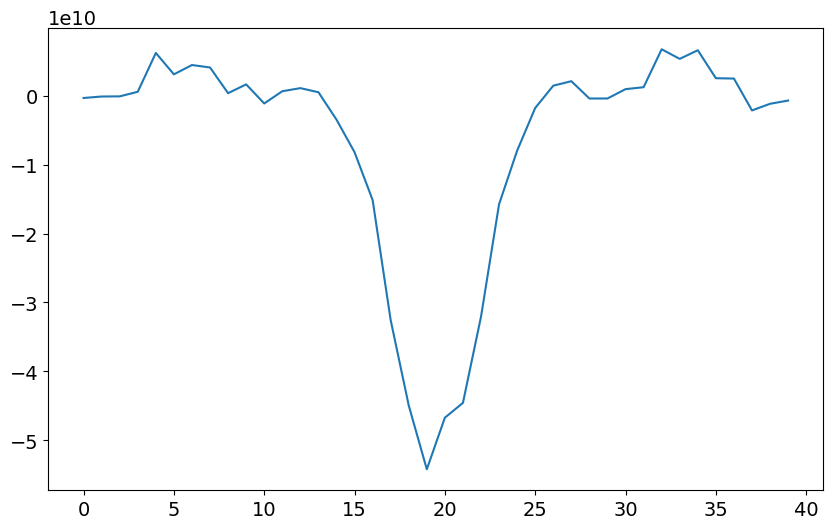

In [ ]:
plt.plot(np.prod((lines-lines.mean())/, axis=0))

## Chi between qubit and Manipulate 

In [115]:
from MM_dual_rail_base import MM_dual_rail_base

# the do function contains 2 calls to ramsey, one with no prepulse and one with prepulse 
# that initializes manipulation mode to 1 state
def do_chi(config_thisrun, expt_path, config_path, prepulse=None, standard_ramsey=True,
           man_mode_no=1):
    """
    Run two Ramsey experiments: one standard, one with a prepulse that initializes manipulation mode 1.
    Returns both experiment objects.
    """
    # Standard Ramsey (no prepulse)
    if standard_ramsey:
        t2ramsey_no_prepulse = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=None, post_sweep_pulse=None, 
                                                step_size=0.1)
    else: 
        t2ramsey_no_prepulse = None

    # Ramsey with prepulse (initialize manipulation mode 1)
    if prepulse is None:
        mm_base_dummy = MM_dual_rail_base(config_thisrun)
        prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
        prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()

    t2ramsey_with_prepulse = do_t2_ramsey_ge(config_thisrun, expt_path, config_path, pre_sweep_pulse=prepulse, post_sweep_pulse=None,
                                                step_size=0.1)

    return t2ramsey_no_prepulse, t2ramsey_with_prepulse

def update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1):
    """
    Update config_thisrun.device.qubit.chi for the given manipulation mode.
    """
    f_without_prepulse = t2_ramsey_original.data['f_adjust_ramsey_avgi'][0]
    f_with_prepulse = t2_ramsey_prepulse.data['f_adjust_ramsey_avgi'][0]
    chi = f_with_prepulse - f_without_prepulse
    print('Chi:', chi)
    config_thisrun.device.manipulate.chi[man_mode_no - 1] = chi
    config_thisrun.device.manipulate.revival_time[man_mode_no-1] = np.abs(np.pi/(2 * np.pi * chi))
    print('Delay time (mus):', config_thisrun.device.manipulate.revival_time[man_mode_no-1] )


fge is  3569.462965491148
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00062_RamseyExperiment.h5
fge is  3569.462965491148
fef is  3426.2579958470365


  0%|          | 0/10000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00063_RamseyExperiment.h5
Attempted to init fitparam 4 to -95.11045356158992, which is out of bounds -241.44194805194806 to -185.17496753246752. Instead init to -213.30845779220778
Attempted to init fitparam 4 to -213.30845779220778, which is out of bounds 195.10469796722958 to 356.44599582715864. Instead init to 275.77534689719414
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 0.21269538809070834 +/- 0.0008396159067629018
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.4502701030574
 	3569.875660879239
T2 Ramsey from fit I [us]: 142.81352774778344
Fit frequency from Q [MHz]: 0.2100035403441782 +/- 0.004005113223192058
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.452961950804
 	3569.8729690314926
T2 Ramsey from fit Q [us]: 6.7630317620075875


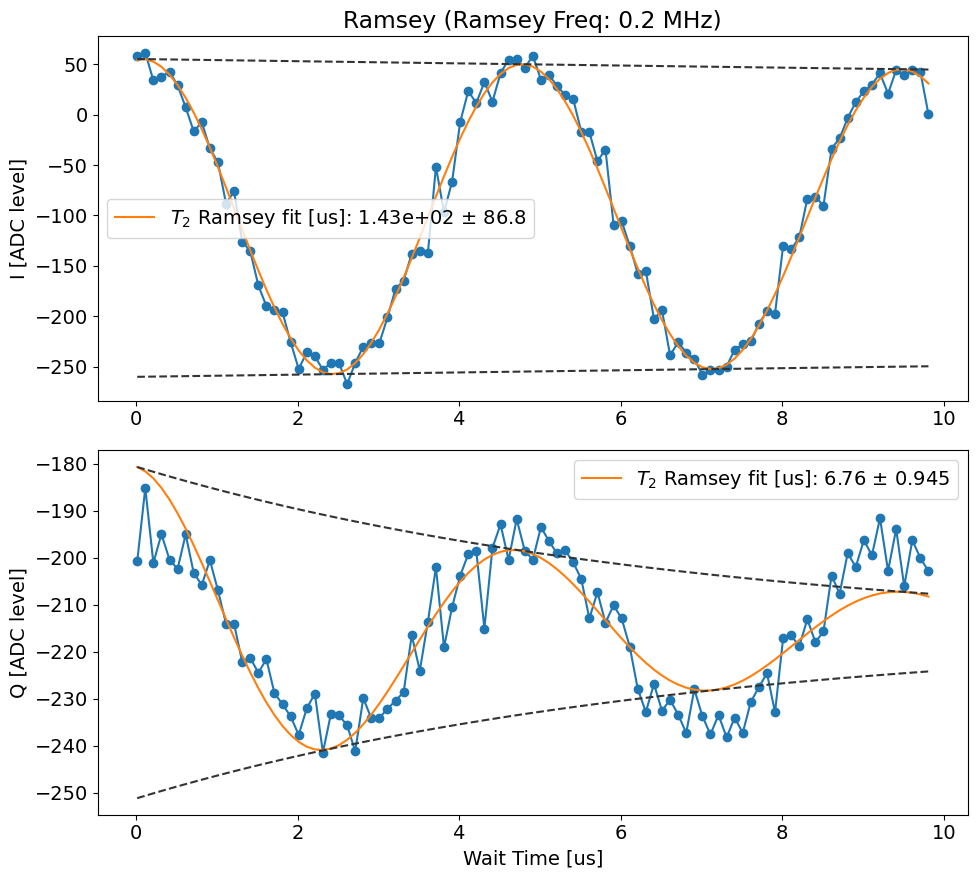

Attempted to init fitparam 4 to -95.94864390659846, which is out of bounds -238.83262987012986 to -177.970487012987. Instead init to -208.40155844155845
Attempted to init fitparam 4 to -208.40155844155845, which is out of bounds 178.16317119024183 to 342.57638338711104. Instead init to 260.36977728867646
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 0.5056226810226293 +/- 0.000848827482405089
Suggested new pi pulse frequency from fit I [MHz]:
 	3569.1573428101256
 	3570.168588172171
T2 Ramsey from fit I [us]: 84.21360554378474
Fit frequency from Q [MHz]: 0.5023580316241741 +/- 0.005239018005397417
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3569.1606074595243
 	3570.1653235227723
T2 Ramsey from fit Q [us]: 6.17165850771561


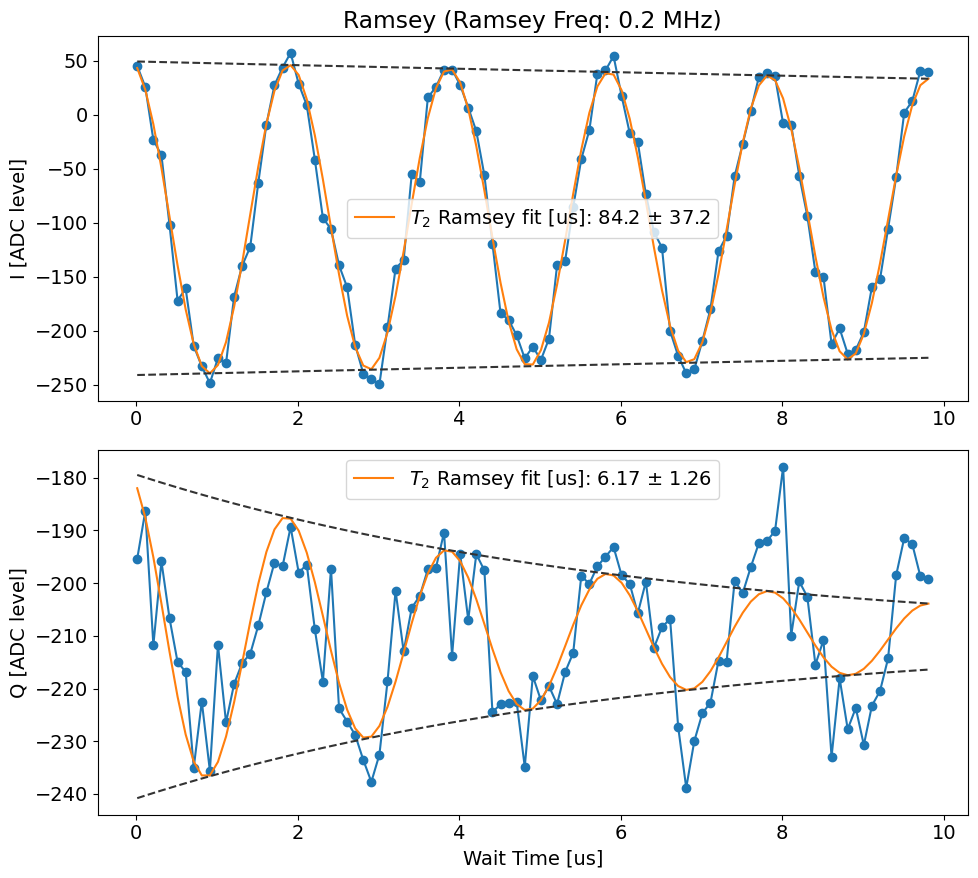

Chi: -0.292927292931921


AttributeError: 'AttrDict' object has no attribute 'chi'

In [106]:
t2_ramsey_original, t2_ramsey_prepulse = None, None
if expts_to_run['chi']:
    # Run the chi experiment
    t2_ramsey_original, t2_ramsey_prepulse = do_chi(config_thisrun, expt_path, config_path, standard_ramsey=True)
    # analyze and display the results
    t2_ramsey_original.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_original.display()
    t2_ramsey_prepulse.analyze(fitparams=[300, None, None, None, None, None])
    t2_ramsey_prepulse.display() 
    # update the config_thisrun with the chi value
    update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)
    print('Only doing it for mode 1')

In [116]:
update_chi(t2_ramsey_original, t2_ramsey_prepulse, config_thisrun, man_mode_no=1)

Chi: -0.292927292931921
Delay time (mus): 1.7069082057717464


In [112]:
config_thisrun.device.manipulate.revival_time[0] = np.pi/(2 * np.pi * config_thisrun.device.manipulate.chi[0])

1.7241379310344829

## Parity Delay
NOT Implemented yet: We can use chi to estimate parity waiting time pi/chi but can also fine tune it using this experiment

Basically Length rabi analysis 

## T1

In [144]:


def do_t1_manipulate(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run T1 experiment for the specified manipulate mode (man_mode_no).
    """
    t1_man = meas.single_qubit.t1_cavity.T1CavityExperiment(
        soccfg=soc, path=expt_path, prefix='T1CavityExperiment', config_file=config_path
    )

    t1_man.cfg = AttrDict(deepcopy(config_thisrun))

    # Set experiment parameters for the specified manipulate mode
    t1_man.cfg.expt = dict(
        start=0,
        step=15,
        expts=60,
        reps=300,
        rounds=1,
        cavity_prepulse=[False, 300, 1.5],
        f0g1_prep=True,
        f0g1_param=[ds_thisrun.get_freq(f'M{man_mode_no}'), ds_thisrun.get_gain(f'M{man_mode_no}'), ds_thisrun.get_pi(f'M{man_mode_no}')],
        resolved_pi=False,
        cavity=man_mode_no,
        qubit=0,
        normalize=False
    )

    t1_man.cfg.device.readout.relax_delay = [2500]
    t1_man.go(analyze=True, display=True, progress=True, save=True)
    return t1_man



  0%|          | 0/18000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00000_T1CavityExperiment.h5
Fit T1 avgi [us]: 245.73319298547162
Fit T1 avgq [us]: 239.08476736949262


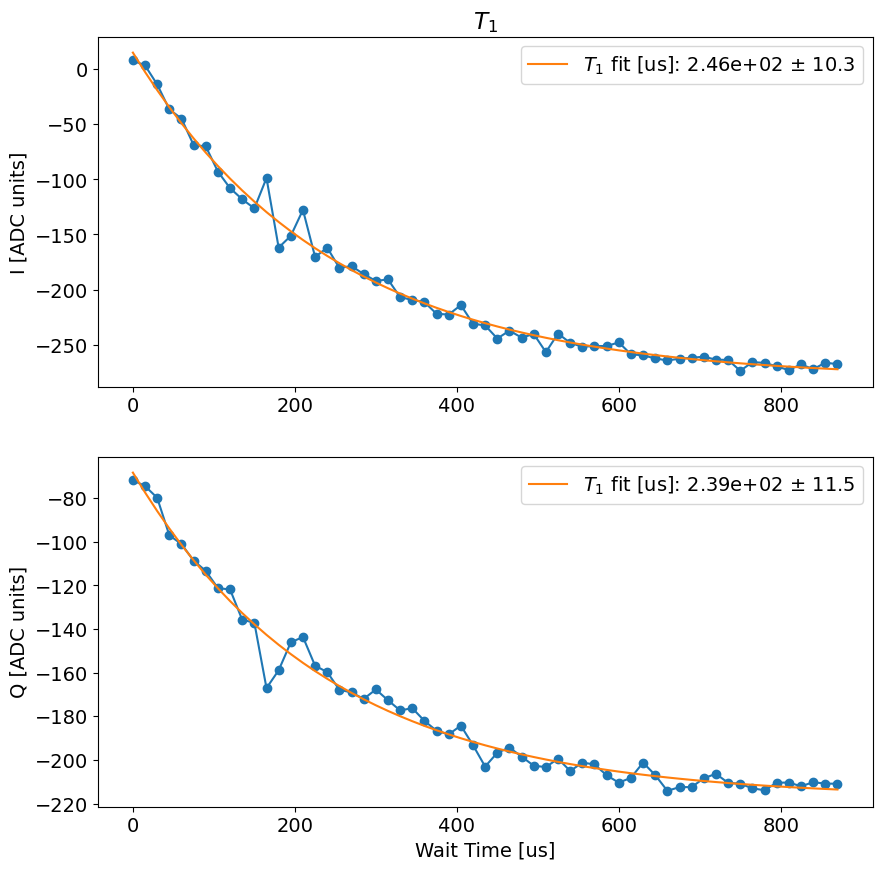

In [ ]:
t1_man = do_t1_manipulate(config_thisrun, expt_path, config_path, 1)

## T2

In [177]:
def do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1):
    """
    Run the Cavity Ramsey experiment using the specified configuration.
    """
    cavity_ramsey = meas.single_qubit.t2_cavity.CavityRamseyExperiment(
        soccfg=soc, path=expt_path, prefix='CavityRamseyExperiment', config_file=config_path
    )

    cavity_ramsey.cfg = AttrDict(deepcopy(config_thisrun))

    # Prepulse and postpulse

    # Set experiment parameters as in the YAML block above
    cavity_ramsey.cfg.expt = dict(
        start=0.01,
        step=0.05,
        expts=100,
        ramsey_freq=3.7,
        reps=50,
        rounds=1,
        qubits=[0],
        checkEF=False,
        f0g1_cavity=0,
        init_gf=False,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        user_defined_pulse=[True, ds_thisrun.get_freq(stor_name='M'+ str(man_mode_no)), 
                            ds_thisrun.get_gain(stor_name='M'+ str(man_mode_no)), 0.005, 
                            ds_thisrun.get_pi(stor_name='M'+ str(man_mode_no)), 0],
        parity_meas=False,
        man_idx=1,
        storage_ramsey=[False, 2, True],
        man_ramsey=[False, man_mode_no],
        coupler_ramsey=False,
        custom_coupler_pulse=[[944.25], [1000], [0.316677658], [0], [1], ['flat_top'], [0.005]],
        echoes=[False, 0],
        prepulse=True,
        postpulse=True,
        gate_based = True,
        pre_sweep_pulse= [['qubit', 'ge', 'hpi', 0], ['qubit', 'ef', 'pi', 0]],
        post_sweep_pulse=[['qubit', 'ef', 'pi', 0], ['qubit', 'ge', 'hpi', 0]]
    )

    cavity_ramsey.cfg.device.readout.relax_delay = [2500]
    cavity_ramsey.go(analyze=False, display=False, progress=True, save=True)
    return cavity_ramsey

cavity_ramsey = do_cavity_ramsey(config_thisrun, expt_path, config_path, man_mode_no=1)

Running f0g1 ramsey
phase update channel: [0]
phase step deg: 66.60000000000001
phase step logic: +
inide t2 cavity acquire
100


  0%|          | 0/5000 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00008_CavityRamseyExperiment.h5


Attempted to init fitparam 1 to 6.8686868686868685, which is out of bounds 0.02040816326530612 to 3.061224489795918. Instead init to 1.540816326530612
Current pi pulse frequency: 3569.462965491148
Fit frequency from I [MHz]: 3.060276703771371 +/- 0.05821304578443343
Suggested new pi pulse frequency from fit I [MHz]:
 	3570.102688787377
 	3576.2232421949197
T2 Ramsey from fit I [us]: 2.6830715424324296
Fit frequency from Q [MHz]: 0.9785645272761624 +/- 0.06768238650507281
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3572.184400963872
 	3574.1415300184244
T2 Ramsey from fit Q [us]: 2.8151631256662872


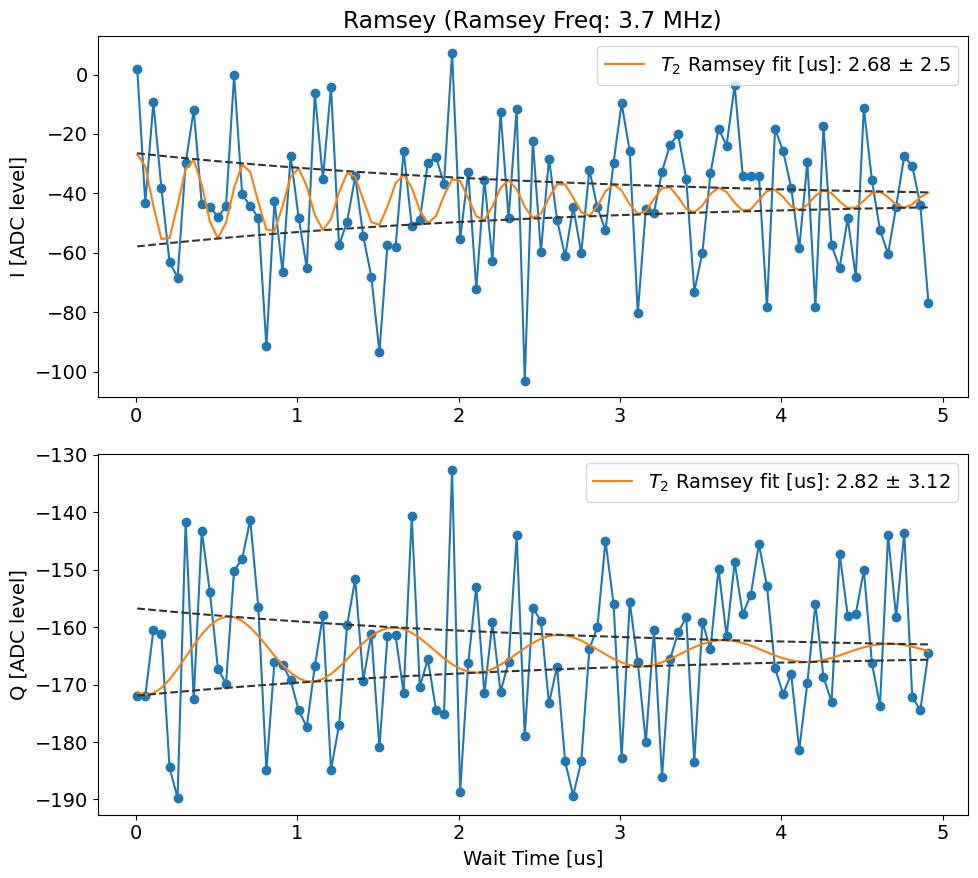

In [178]:
cavity_ramsey.analyze()
cavity_ramsey.display()

# Storage

## Stor Spectroscopy

In [158]:
def get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no):
    """
    Get pulse parameters for a given storage mode. 
    Also returns prepulse and postpulse (single photon prep and meas for ge meas)

    Args:
        ds_thisrun: Dataset object for managing frequency data.
        config_thisrun: Configuration dictionary for the current run.
        man_mode_no: Manipulation mode number.
        stor_mode_no: Storage mode number.

    Returns:
        A tuple containing freq, gain, ch, prepulse, and postpulse.
    """
    freq = ds_thisrun.get_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    gain = ds_thisrun.get_gain('M' + str(man_mode_no) + '-S' + str(stor_mode_no))
    ch = 'low' if freq < 1000 else 'high'

    from MM_dual_rail_base import MM_dual_rail_base
    mm_base_dummy = MM_dual_rail_base(config_thisrun)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist() # for ge meas, only do f0g1 and ef pi

    return freq, gain, ch, prepulse, postpulse


def do_stor_spectroscopy(config_thisrun, ds_thisrun,  expt_path, config_path, man_mode_no = 1, stor_no = 1):
    """
    Run the Flux Spectroscopy F0g1 Experiment.

    This function performs a flux spectroscopy experiment to measure the transition frequency
    between the f0 and g1 states of a qubit. It configures the experiment parameters, executes
    the experiment, and saves the results.

    Args:
        config_thisrun (AttrDict): Configuration dictionary for the current run.
        ds_thisrun (dataset.storage_man_swap_dataset): Dataset object for managing frequency data.
        expt_path (str): Path to save the experiment results.
        config_path (str): Path to the configuration file.
        man_mode_no (int, optional): Manipulation mode number (default is 1).
        stor_no (int, optional): Storage mode number (default is 1).

    Returns:
        FluxSpectroscopyF0g1Experiment: The experiment object containing the results.
    """
    flux_spec = meas.single_qubit.rf_flux_spectroscopy_f0g1.FluxSpectroscopyF0g1Experiment(
        soccfg=soc, path=expt_path, prefix='FluxSpectroscopyF0g1Experiment', config_file=config_path
    )

    flux_spec.cfg = AttrDict(deepcopy(config_thisrun))

    freq, gain,ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun,
                                                                      man_mode_no, stor_no)

    flux_spec.cfg.expt = dict(
        start=freq - 15,  # Start RF frequency [MHz]
        step=0.15,  # Step size [MHz]
        expts=200,  # Number of experiments
        reps=100,  # Number of averages per point
        qubit=[0],
        flux_drive=[ch, 1,5000, 1],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )

    flux_spec.cfg.device.readout.relax_delay = [500]  # Wait time between experiments [us]
    flux_spec.go(analyze=False, display=False, progress=True, save=True)
    return flux_spec



def analyze_and_display_stor_spectroscopy(flux_spec):
    """Analyze and display results of Flux Spectroscopy F0g1 Experiment."""
    from multimode_expts.fit_display_classes import Spectroscopy
    spec_analysis = Spectroscopy(flux_spec.data)
    spec_analysis.analyze(fit=True)
    spec_analysis.display()


def update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no = 1, stor_no = 1):
    """Update the configuration based on Flux Spectroscopy F0g1 experiment results."""
    # Update the dataset with the new frequency
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_no), flux_spec.data['fit_avgi'][2])
    print(f"Updated frequency for M{man_mode_no}-S{stor_no}: {flux_spec.data['fit_avgi'][2]}")


In [104]:
ds_thisrun.update_freq('M1-S2', 520)

Running flux spectroscopy f0g1 for mode 1


  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00035_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 348.0052001187364, HWHM 1.2412066730721865
Found peak in I at [MHz] 348.2197174269142, HWHM 1.640551713115102
Found peak in Q at [MHz] 349.2924017553497, HWHM 3.7133525661026057


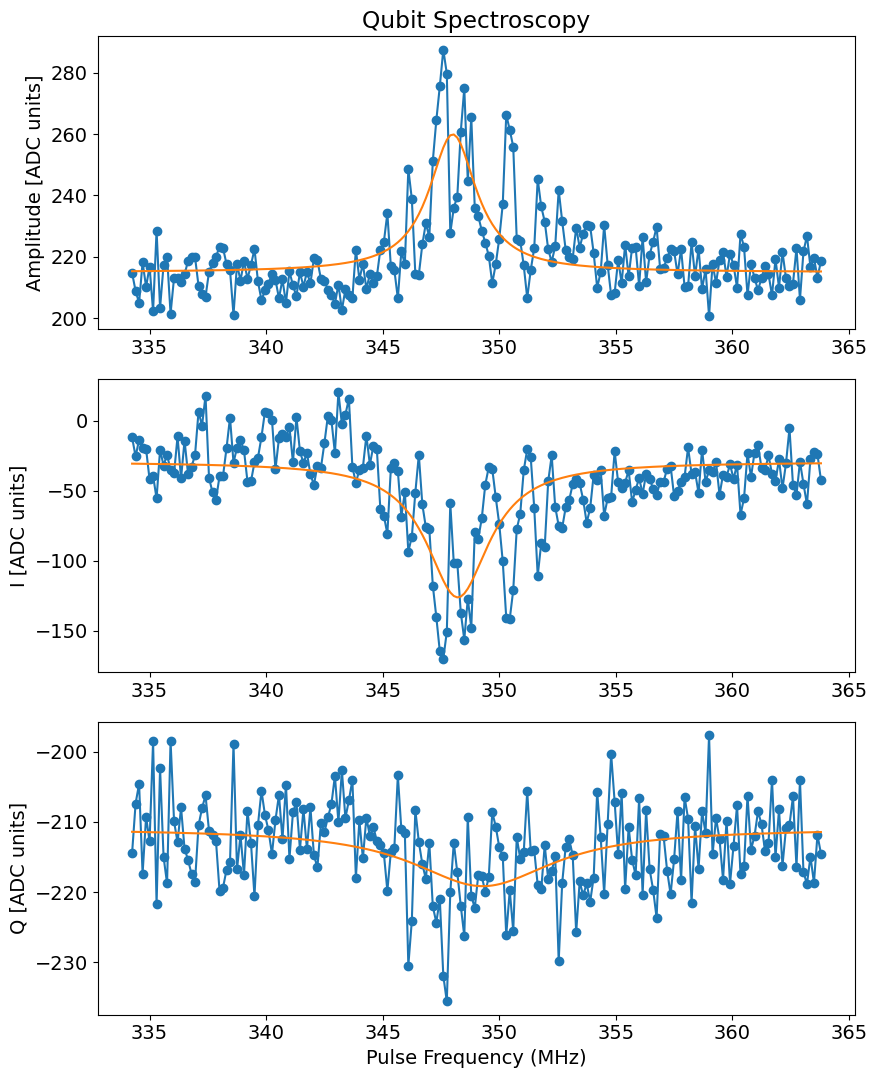

Updated frequency for M1-S1: 348.2197174269142
Running flux spectroscopy f0g1 for mode 2


KeyboardInterrupt: 

In [102]:
stor_specs = [None]* len(expts_to_run['stor_modes'])
for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['stor_spectroscopy']:
        print('Running flux spectroscopy f0g1 for mode', i+1)
        flux_spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
        stor_specs[i] = flux_spec
        analyze_and_display_stor_spectroscopy(flux_spec)
        update_stor_spectroscopy(flux_spec, ds_thisrun, man_mode_no=1, stor_no=i+1)

  0%|          | 0/200 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\00036_FluxSpectroscopyF0g1Experiment.h5
Found peak in amps at [MHz] 516.527951397539, HWHM 14.775229844033928
Found peak in I at [MHz] 519.5033741703202, HWHM 2.7278676958656463
Found peak in Q at [MHz] 534.3007028572382, HWHM 7.301167510216929


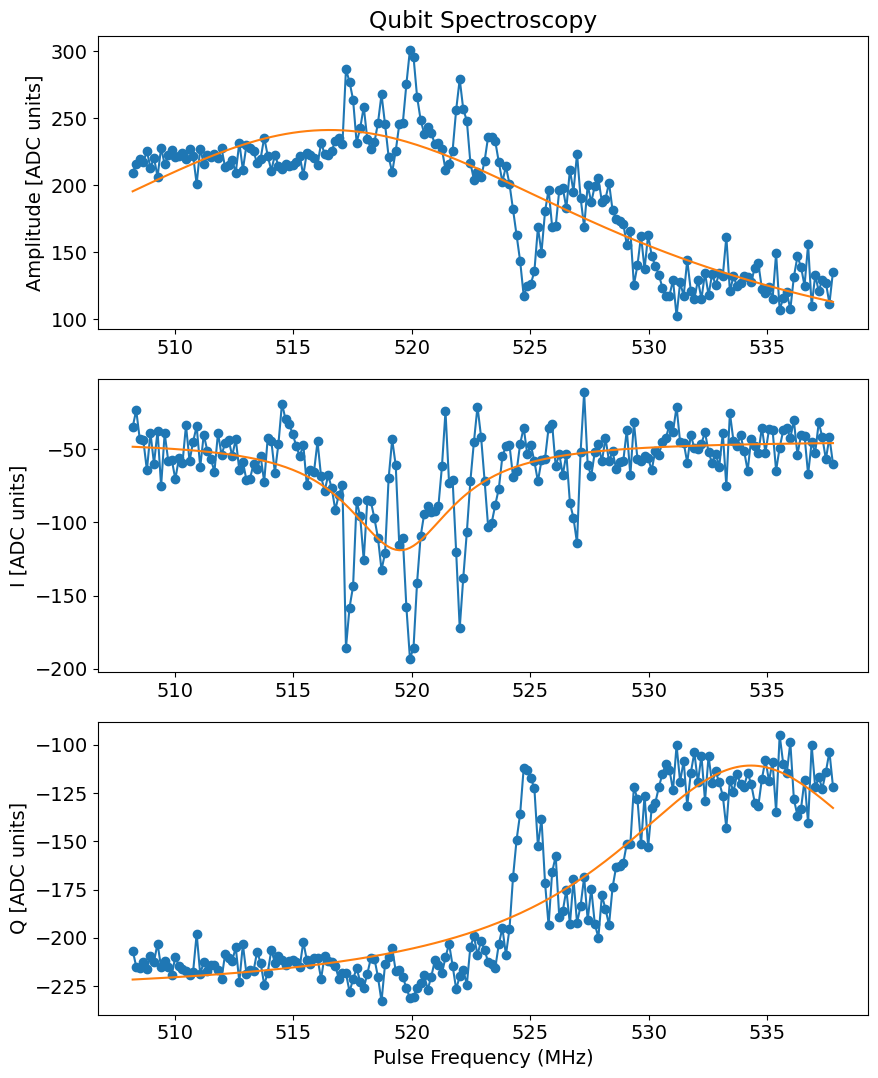

In [103]:
i = 1
spec = do_stor_spectroscopy(config_thisrun, ds_thisrun, expt_path, config_path, man_mode_no=1, stor_no=i+1)
analyze_and_display_stor_spectroscopy(spec)

## Find Frequency (Chevron)

In [159]:
def do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step,
                              man_mode_no = 1, stor_mode_no = 1, start_time = 0.007):
    """Run the Sideband General Sweep Experiment."""
    from multimode_expts.sequential_experiment_classes import sidebands_class
    experiment_class = sidebands_class
    sweep_experiment_name = 'sideband_general_sweep'
    class_for_exp = experiment_class(soccfg=soc, path=expt_path, prefix=sweep_experiment_name, config_file=config_path, exp_param_file=exp_param_file)

    class_for_exp.yaml_cfg = AttrDict(deepcopy(config_thisrun))
    # get pulse parameters for the given storage mode
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)
    
    class_for_exp.loaded[sweep_experiment_name] =  dict(
        start=start_time,  # Pulse start length [us]
        step=0.1,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=100,
        rounds=1,
        freq_start=freq_start,
        freq_stop=freq_stop,
        freq_step=freq_step,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation parameters [low/high (ch), freq (will be overwritten), gain, length(us)]
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse= prepulse,
        post_sweep_pulse= postpulse,
    )
    class_for_exp.yaml_cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]

    return eval('class_for_exp.run_sweep')( sweep_experiment_name = sweep_experiment_name)


def update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=1):
    """Update sweep data and analyze results."""
    temp_data, attrs, filename = prev_data(expt_path, prefix='sideband_general_sweep')
    print('File saved at:', filename)

    from multimode_expts.fit_display_classes import ChevronFitting
    from datetime import datetime
    chevron_analysis = ChevronFitting(
        frequencies=temp_data['freq_sweep'],
        time=temp_data['xpts'][0],
        response_matrix=temp_data['avgi']
    )
    chevron_analysis.analyze()
    
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    chevron_analysis.display_results(save_fig=True, directory=autocalib_path, title=f'M{man_mode_no}-S{stor_mode_no}_{current_time}')

    # Update dataset
    ds_thisrun.update_freq('M' + str(man_mode_no) + '-S' + str(stor_mode_no),chevron_analysis.results['best_frequency_contrast'])
    print('Updated the frequency to:', chevron_analysis.results['best_frequency_contrast'])
    return chevron_analysis

Fitting basically doesn't work when starting from say 20us for a fine sweep, where the chevron is narrower than starting from 0us. Doing things by eye atm.

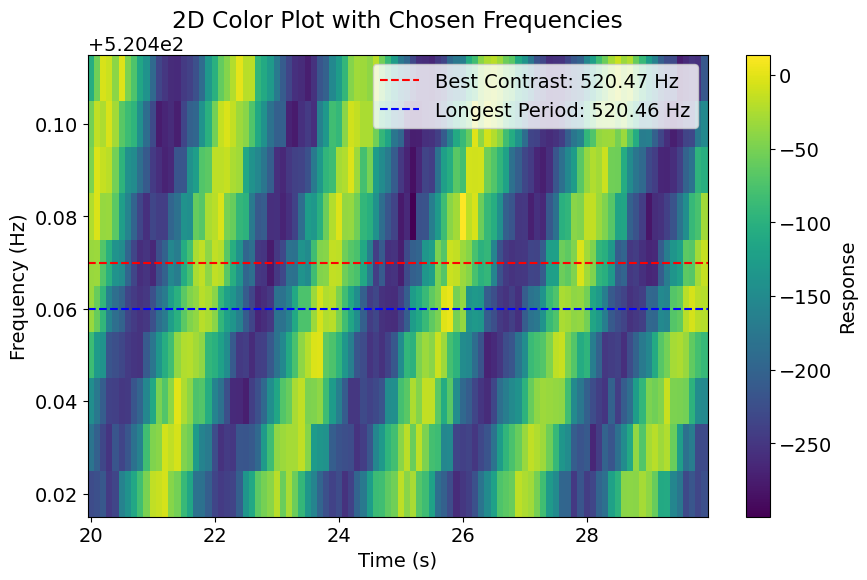

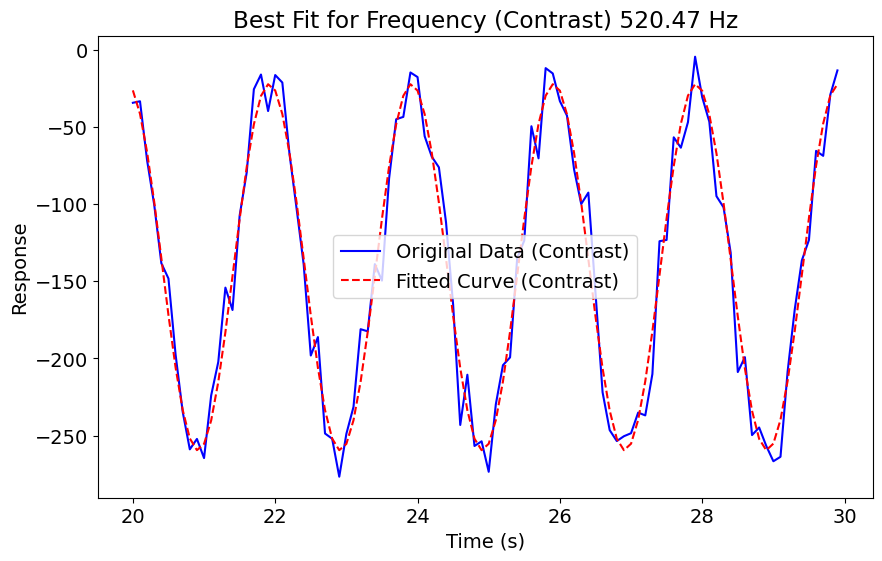

Index: 10 Freq. = 520.5199999999999 MHz
Waiting for 8000 us


KeyboardInterrupt: 

In [160]:
sideband_chevrons_coarse = [None] * len(expts_to_run['stor_modes'])
sideband_chevrons_fine = [None] * len(expts_to_run['stor_modes'])

for i in range(len(expts_to_run['stor_modes'])):
    if expts_to_run['sideband_freq_sweep']:
        # print(f'Running coarse sideband sweep for storage mode {i + 1}')
        # freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 2
        # freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 2
        # freq_step = 0.2
        # sideband_chevrons_coarse[i] = do_sideband_general_sweep(config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, man_mode_no=1, stor_mode_no=i + 1)
        # update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

        print(f'Running fine sideband sweep for storage mode {i + 1}')
        freq_start = ds_thisrun.get_freq('M1-S' + str(i + 1)) - 0.2
        freq_stop = ds_thisrun.get_freq('M1-S' + str(i + 1)) + 0.2
        freq_step = 0.01
        sideband_chevrons_fine[i] = do_sideband_general_sweep(
            config_thisrun, ds_thisrun, expt_path, config_path, freq_start, freq_stop, freq_step, 
            man_mode_no=1, stor_mode_no=i + 1, start_time=20)
        update_sideband_general_sweep(expt_path, config_thisrun, ds_thisrun, man_mode_no=1, stor_mode_no=i + 1)

### Manually get the frequencies from the chevrons

In [204]:
# file_list = np.arange(42,50, 1)
# chevrons_stor_objects = [None]* len(file_list)
# name = '_sideband_general_sweep.h5'
# # name = '_storage_sideband_sweep.h5'
# for idx, file_no in enumerate(file_list):
#     full_name = str(file_no).zfill(5)+name
#     expt_path_mod = r"H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data"
#     temp_data, attrs, filename = prev_data(expt_path_mod, full_name)  # ef

#     from multimode_expts.fit_display_classes import ChevronFitting
#     chevron_analysis = ChevronFitting(
#         frequencies=temp_data['freq_sweep'],
#         time=temp_data['xpts'][0],
#         response_matrix=temp_data['avgi']
#     )
#     chevrons_stor_objects[idx] = chevron_analysis

c:\Users\26049\.conda\envs\slab\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\_Lib\python\multimode_expts\fit_display_classes.py:710: RuntimeWarning: overflow encountered in exp
  return A * np.sin(omega * t + phi) * np.exp(-t / tau) + C
C:\_Lib\python\multimode_expts\fit_display_classes.py:710: RuntimeWarning: overflow encountered in multiply
  return A * np.sin(omega * t + phi) * np.exp(-t / tau) + C


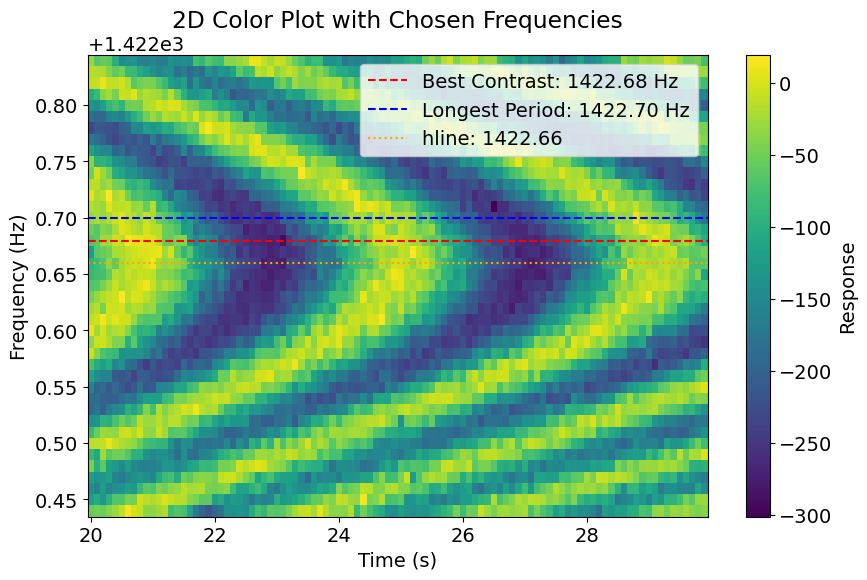

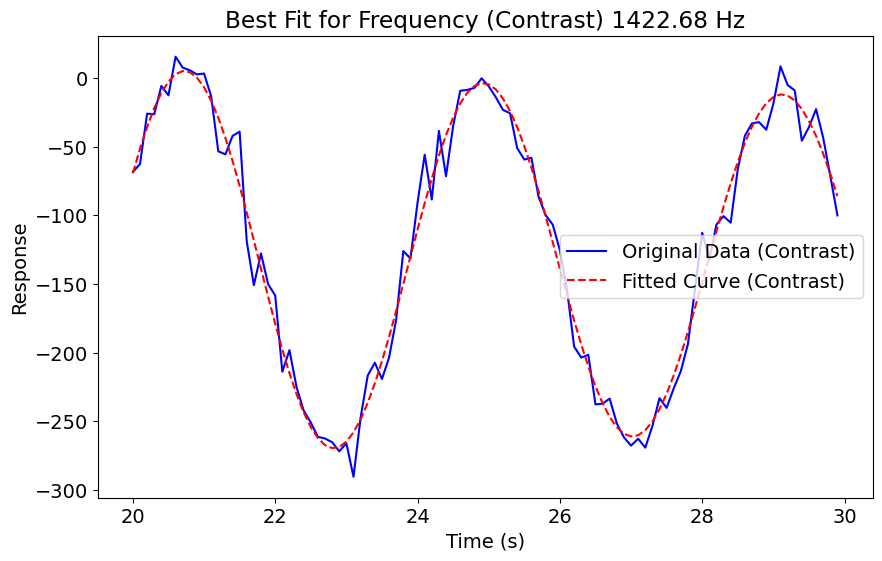

In [ ]:
# i = 7
# guess_freq = 1422.66
# chevrons_stor_objects[i].analyze()
# chevrons_stor_objects[i].display_results(save_fig=False, directory=autocalib_path, title=f'M1-S2_{0}', hlines = [guess_freq])

In [ ]:

# ds_thisrun.update_freq('M1-S' + str(i), guess_freq)

## Sideband General

In [205]:
def do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no = 1,stor_mode_no=1):
    """Run the Sideband General Experiment."""
    
    sideband_general = meas.single_qubit.sideband_general.SidebandGeneralExperiment(
        soccfg=soc, path=expt_path, prefix='SidebandGeneralExperiment', config_file=config_path
    )

    sideband_general.cfg = AttrDict(deepcopy(config_thisrun))

    # Sideband general experiment parameters
    freq, gain, ch, prepulse, postpulse = get_storage_mode_parameters(ds_thisrun, config_thisrun, man_mode_no, stor_mode_no)

    sideband_general.cfg.expt = dict(
        start=0.007,  # Pulse start length [us]
        step=0.05,  # Pulse step length [us]
        qubits=[0],
        expts=100,
        reps=500,
        rounds=1,
        flux_drive=[ch, freq, gain, 0.05],  # RF flux modulation
        prepulse=True,
        postpulse=True,
        active_reset=False,
        man_reset=True,
        storage_reset=True,
        update_post_pulse_phase=[False, 1.07],
        pre_sweep_pulse=prepulse,
        post_sweep_pulse=postpulse,
    )

    sideband_general.cfg.device.readout.relax_delay = [8000]  # Wait time between experiments [us]
    sideband_general.go(analyze=False, display=False, progress=True, save=True)
    return sideband_general


def update_sideband_general(sideband_general, config_thisrun, ds, man_mode_no=1, stor_mode_no=1):
    """Update the configuration and dataset based on Sideband General experiment results."""
    # Analyze the data
    from multimode_expts.fit_display_classes import LengthRabiFitting
    sideband_analysis = LengthRabiFitting(sideband_general.data)
    sideband_analysis.analyze()
    sideband_analysis.display(title_str='Sideband General', save_fig=True)

    # Update dataset
    pi_length = sideband_analysis.results['pi_length']
    pi2_length = sideband_analysis.results['pi2_length']
    gain = sideband_general.cfg.expt['flux_drive'][2]
    freq = sideband_general.cfg.expt['flux_drive'][1]
    ds.update_all('M' + str(man_mode_no) + '-S' + str(stor_mode_no), freq, np.nan, pi_length, pi2_length, gain)
    print(f'Updated configuration and dataset: pi_length={pi_length}, pi2_length={pi2_length}, gain={gain}')



Running sideband general for manipulation mode 1 and storage mode 1


  0%|          | 0/100 [00:00<?, ?it/s]

Saving H:\Shared drives\SLab\Multimode\experiment\250505_craqm\data\00000_SidebandGeneralExperiment.h5
Pi length: 0.8136270373570066
Pi/2 length: 0.36051300259229946
Pi length: 0.8250310937352237
Pi/2 length: 0.36863274796112716


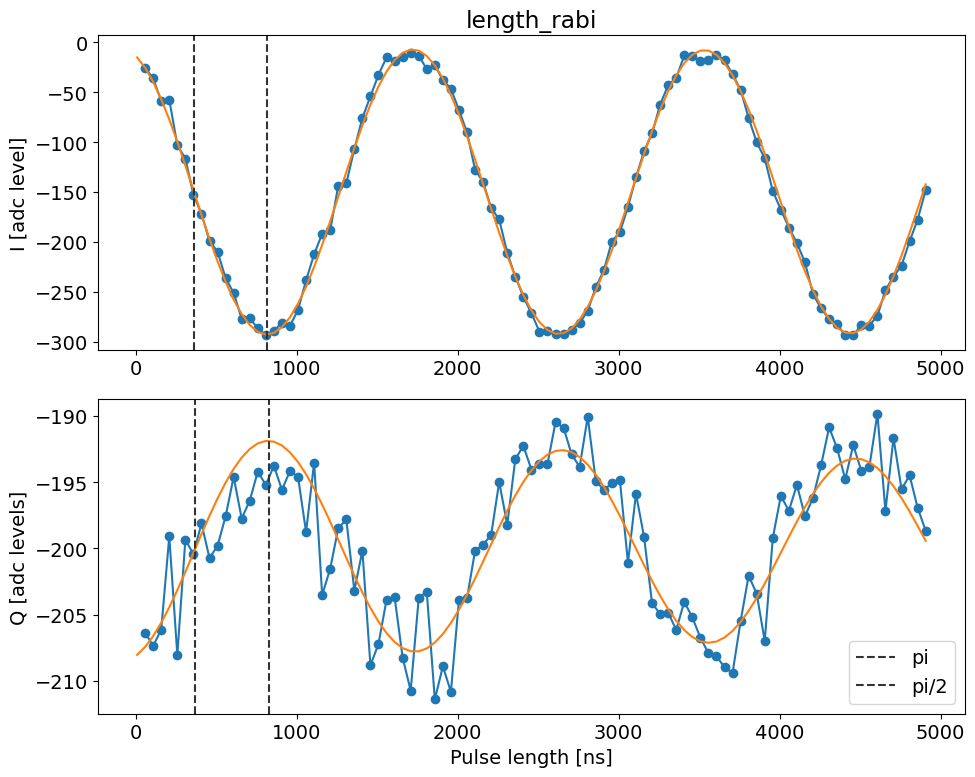

supertitle is  None
Plot saved to plots\2025-05-22_16-05-21_Sideband_General.png
Updated configuration and dataset: pi_length=0.8136270373570066, pi2_length=0.36051300259229946, gain=3000
Running sideband general for manipulation mode 1 and storage mode 2


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [206]:
len_rabi_storages = [None]* len(expts_to_run['stor_modes'])
if expts_to_run['sideband_length_rabi']:
    for man_mode_no in expts_to_run['man_modes']:
        for stor_mode_no in expts_to_run['stor_modes']:
            print(f'Running sideband general for manipulation mode {man_mode_no} and storage mode {stor_mode_no}')
            len_rabi_storages[stor_mode_no-1] = do_sideband_general(config_thisrun, expt_path, config_path, man_mode_no, stor_mode_no)
            update_sideband_general(len_rabi_storages[stor_mode_no-1], config_thisrun, ds_thisrun, man_mode_no, stor_mode_no)


In [212]:
pi_l = 0.6303030824111784
hpi_l = 0.3104829303763078
(pi_l - hpi_l)*2 + pi_l

1.2699433864809195

In [ ]:
# ds_thisrun.update_freq('M1-S1', 349.01)
# ds_thisrun.update_freq('M1', 2009.01)

In [221]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


Estimated Resonant Point: Time = 21.04 s, Frequency = 348.90 Hz


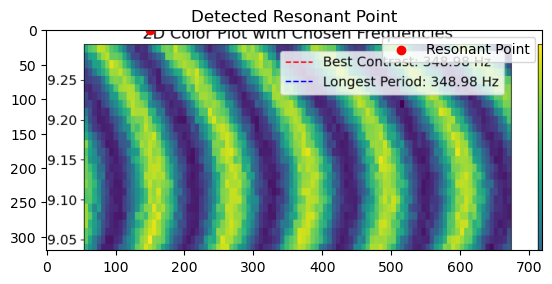

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the image
image_path =r"H:\Shared drives\SLab\Multimode\experiment\250505_qsim\data\autocalibration_plots_2025-05-21\M1-S1_2025-05-21_18-23-48.png"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Crop the plot area manually (or use auto-detection if needed)
# Assuming axes are roughly aligned and always in the same place
plot_area = img_rgb[50:370, 70:790]  # Adjust these if needed

# Convert to grayscale for intensity analysis
gray = cv2.cvtColor(plot_area, cv2.COLOR_RGB2GRAY)

# Invert to make bright areas high value
inv_gray = cv2.bitwise_not(gray)

# Find coordinates of the maximum region
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(inv_gray)

# Get the pixel coordinates of the max point
px_y, px_x = max_loc[1], max_loc[0]

# Map pixel coordinates back to real data axes
# Time: 20 to 25 seconds -> 0 to width
# Frequency: 348.9 to 349.3 Hz -> 0 to height
time_start, time_end = 20, 25
freq_start, freq_end = 348.9, 349.3

time_range = time_end - time_start
freq_range = freq_end - freq_start

img_height, img_width = gray.shape

resonant_time = time_start + (px_x / img_width) * time_range
resonant_freq = freq_start + (px_y / img_height) * freq_range

print(f"Estimated Resonant Point: Time = {resonant_time:.2f} s, Frequency = {resonant_freq:.2f} Hz")

# Optional: Show the image with the detected point
plt.imshow(plot_area)
plt.scatter(px_x, px_y, color='red', label='Resonant Point')
plt.title("Detected Resonant Point")
plt.legend()
plt.show()


In [7]:
import matplotlib.pyplot as plt

# Save your plots
plot_paths = []
for i in range(3):
    plt.figure()
    plt.plot([0, 1, 2], [i, i+1, i+2])
    plt.title(f"Plot {i+1}")
    plot_path = f"plot_{i+1}.png"
    plt.savefig(plot_path)
    plt.close()
    plot_paths.append(plot_path)

# Path to your existing markdown file
markdown_file = "your_existing_file.md"

# Append image links to the markdown file
with open(markdown_file, "a") as f:
    for i, path in enumerate(plot_paths):
        f.write(f"![Plot {i+1}]({path})\n")


# Update Config and Dataset

In [139]:
def convert_attrdict_to_dict(attrdict):
    """
    Recursively converts an AttrDict or a nested dictionary into a standard Python dictionary.
    Converts np.float64 values to standard Python float.

    Args:
        attrdict (AttrDict or dict): The input AttrDict or dictionary to be converted.

    Returns:
        dict: A standard Python dictionary with all nested AttrDicts or dictionaries converted.
    """
    if isinstance(attrdict, AttrDict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, dict):
        return {key: convert_attrdict_to_dict(value) for key, value in attrdict.items()}
    elif isinstance(attrdict, np.float64):
        return float(attrdict)
    else:
        return attrdict


def convert_numbers_to_float(data):
    """
    Recursively converts all numbers in a dictionary to float.

    Args:
        data (dict): The input dictionary.

    Returns:
        dict: A dictionary with all numbers converted to float.
    """
    if isinstance(data, dict):
        return {key: convert_numbers_to_float(value) for key, value in data.items()}
    elif isinstance(data, list):
        return [convert_numbers_to_float(item) for item in data]
    elif isinstance(data, float):
        return float(data)
    elif isinstance(data, int):
        return int(data)
    else:
        return data

## Dataset

In [207]:
#compare the two datsets
differences = ds_thisrun.compare_with(ds)
# Filter out differences related to 'last_update' column
filtered_differences = [diff for diff in differences if diff['column'] != 'last_update']
# Update labels and calculate differences
for diff in filtered_differences:
    diff['label'] = f"New value: {diff['self_value']}, Old value: {diff['other_value']}"
    diff['difference'] = diff['self_value'] - diff['other_value'] if isinstance(diff['self_value'], (int, float)) and isinstance(diff['other_value'], (int, float)) else None

# Group differences by storage name
grouped_differences = {}
for diff in filtered_differences:
    stor_name = diff['stor_name']
    if stor_name not in grouped_differences:
        grouped_differences[stor_name] = []
    grouped_differences[stor_name].append(diff)

# Print grouped differences
for stor_name, diffs in grouped_differences.items():
    print(f"In {stor_name}:")
    for diff in diffs:
        print(f"  Column '{diff['column']}': new_value = {diff['self_value']}, old_value = {diff['other_value']}, difference = {diff['difference']}")
    grouped_differences[stor_name].append(diff)


In M1-S1:
  Column 'freq (MHz)': new_value = 349.11, old_value = 349.1, difference = 0.009999999999990905
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
  Column 'pi (mus)': new_value = 0.8136270373570066, old_value = 0.8201372985153619, difference = -0.0065102611583552905
  Column 'h_pi (mus)': new_value = 0.36051300259229946, old_value = 0.3686429924850567, difference = -0.008129989892757261
In M1-S2:
  Column 'freq (MHz)': new_value = 520.61, old_value = 520.62, difference = -0.009999999999990905
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S3:
  Column 'freq (MHz)': new_value = 696.35, old_value = 696.3389248854922, difference = 0.011075114507775652
  Column 'precision (MHz)': new_value = nan, old_value = nan, difference = nan
In M1-S4:
  Column 'freq (MHz)': new_value = 875.285, old_value = 875.3220680273886, difference = -0.0370680273886137
  Column 'precision (MHz)': new_value = nan, old_value = nan, differe

In [208]:
ds_thisrun.df

stor_name  freq (MHz)  precision (MHz)   pi (mus)  h_pi (mus)  \
0      M1-S1     349.110              NaN   0.813627    0.360513   
1      M1-S2     520.610              NaN   0.165878    0.080903   
2      M1-S3     696.350              NaN   1.122884    0.512333   
3      M1-S4     875.285              NaN   1.068157    0.488362   
4      M1-S5    1053.040              NaN   1.744303    0.833387   
5      M1-S6    1244.860              NaN   1.388454    0.652345   
6      M1-S7    1422.660              NaN   1.993553    0.948300   
7      M1-S8      -1.000            -1.00  -1.000000   -1.000000   
8      M1-S9      -1.000            -1.00  -1.000000   -1.000000   
9     M1-S10      -1.000            -1.00  -1.000000   -1.000000   
10    M1-S11      -1.000            -1.00  -1.000000   -1.000000   
11    M1-S12      -1.000            -1.00  -1.000000   -1.000000   
12        M1    2008.975              NaN   0.630303    0.310483   
13        M2    1834.950             0.01   1.054456    0.520515   
14     M2-S1     175.630             0.01   2.173484    1.086742   
15     M2-S2     346.840             0.01   0.908835    0.454417   
16     M2-S3     523.220             0.01   1.561615    0.780808   
17     M2-S4     702.650             0.01   1.386764    0.693382   
18     M2-S5     878.780             0.01   1.303372    0.651686   
19     M2-S6    1070.100             0.01   2.379622    1.189811   
20     M2-S7    1249.700             0.01   1.796981    0.898491   
21     M2-M1     173.790             0.01   0.463481    0.231741   
22     M1-D1    2313.440             0.01  10.000000    0.000000   
23     M2-D2    2094.050             0.01  15.000000    0.000000   
24      M1-C     973.230             0.02   0.251127    0.122354   
25     M1_ce    2008.780             0.02   0.617915    0.304523   

    gain (DAC units)                 last_update  
0               3000  2025-05-22 16:05:21.623488  
1               5000  2025-05-22 15:50:43.604290  
2               9000  2025-05-22 15:50:34.895075  
3               9000  2025-05-22 15:54:56.582975  
4               7500  2025-05-22 15:55:49.320754  
5              13500  2025-05-22 15:56:51.940958  
6              10000  2025-05-22 15:57:38.027389  
7                 -1                     51:31.3  
8                 -1                     51:31.3  
9                 -1                     51:31.3  
10                -1                     51:31.3  
11                -1                     51:31.3  
12             15000  2025-05-22 11:41:48.460289  
13             15000  2025-04-30 11:22:11.432806  
14              1000                     28:20.8  
15              5000                     33:56.1  
16              5000                     22:30.3  
17              9000                     25:33.1  
18             13500                     00:05.4  
19              9000                     30:59.0  
20             12000                     56:07.5  
21              2000  2024-10-06 01:47:25.946153  
22              5000  2025-01-23 14:54:56.384507  
23              8000  2025-01-23 17:22:53.776061  
24              1000  2025-01-20 09:34:00.029234  
25             15000  2025-01-20 09:52:35.311227

In [210]:
# stor new datset at old file path
updateDataset = False
if updateDataset:
    # store old dataset  into autocalib_path with date-time in the name
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_dataset_path = os.path.join(autocalib_path, f'old_dataset_{current_time}.h5')
    ds_thisrun.save_to_file(old_dataset_path)
    print('Old dataset saved to:', old_dataset_path)

    #save new dataset to curreent_dataset path
    ds_thisrun.save_to_file(ds.filename)
    # ds = copy(ds_thisrun)
    print('New dataset saved to old file path!')

## Config

In [211]:
from pprint import pprint
print("Comparing configurations:")

def recursive_compare(d1, d2, path=""):
    for key in d1.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d2:
            print(f"Key '{current_path}' is missing in config2.")
        elif isinstance(d1[key], dict) and isinstance(d2[key], dict):
            recursive_compare(d1[key], d2[key], current_path)
        elif d1[key] != d2[key]:
            print(f"Key '{current_path}' differs:")
            if isinstance(d1[key], list) and len(d1[key]) == 1:
                print(f"  Old value (config1): {d1[key][0]}")
                print(f"  New value (config2): {d2[key][0]}")
            else:
                print(f"  Old value (config1): {d1[key]}")
                print(f"  New value (config2): {d2[key]}")
    for key in d2.keys():
        current_path = f"{path}.{key}" if path else key
        if key not in d1:
            print(f"Key '{current_path}' is missing in config1.")

recursive_compare(yaml_cfg, config_thisrun)

Comparing configurations:
Key 'device.storage.storage_man_file' differs:
  Old value (config1): C:/_Lib/python/multimode_expts/man1_storage_swap_dataset.csv
  New value (config2): C:\_Lib\python\multimode_expts\man1_storage_swap_dataset_copy.csv


In [ ]:
# Copy contents from config_thisrun to yaml_cfg except for the storage_man_file
def update_yaml_config(yaml_cfg, config_thisrun):
    """
    Update the yaml_cfg with values from config_thisrun, excluding the storage_man_file.
    """
    updated_config = deepcopy(config_thisrun)
    updated_config.device.storage.storage_man_file = yaml_cfg.device.storage.storage_man_file
    return updated_config

def save_configurations(yaml_cfg, config_thisrun, autocalib_path, config_path):
    """
    Save the old and updated configurations to their respective files.
    """
    # Save old configuration
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    old_config_path = os.path.join(autocalib_path, f'old_config_{current_time}.yaml')
    old_config = convert_numbers_to_float(convert_attrdict_to_dict(yaml_cfg) )
    with open(old_config_path, 'w') as cfg_file:
        yaml.dump(old_config, cfg_file, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

    # Save updated configuration
    updated_config = convert_numbers_to_float(convert_attrdict_to_dict(update_yaml_config(yaml_cfg, config_thisrun)))
    with open(config_path, 'w') as f:
        yaml.dump(updated_config, f, default_flow_style=False, indent=4, width=80, canonical=False,
                  explicit_start=True, explicit_end=False, sort_keys=False, line_break=True)

# Main logic
updateConfig_bool = False# Set to FALSE after this run!!!!!!
updated_config = update_yaml_config(yaml_cfg, config_thisrun)
if updateConfig_bool:
    save_configurations(yaml_cfg, updated_config, autocalib_path, config_path)
    yaml_cfg = updated_config
    updateConfig_bool = False
    print("Configuration updated and saved, excluding storage_man_file. \n!!!!Please set updateConfig to False after this run!!!!!!.")

Configuration updated and saved, excluding storage_man_file. 
!!!!Please set updateConfig to False after this run!!!!!!.
